## Data Loading and Preprocessing

In this section, we will load the dataset containing the preliminary preprocessing steps which was done before feature engineering in Assignment 2. This dataset serves as a clean slate, devoid of the features previously created, allowing us to re-evaluate each one based on the new criteria and objectives of the current assignment.

### Objectives

1. **Evaluate Each Feature**: We will assess each feature from Assignment 2 to determine its relevance and effectiveness for anomaly detection in credit card transactions.
2. **Feature Refinement**: Based on our evaluation, we will refine each feature. This might involve altering the calculation methods, transforming them into ratios, or normalizing the data to enhance the model's predictive capabilities.
3. **Addition or Replacement**: Where necessary, we will introduce new features or replace less effective ones with those that better capture the nuances of the dataset and the anomaly detection goals.
4. **Finalize Dataset for Modeling**: Prepare and save the revised dataset, ensuring it is optimized for subsequent use in unsupervised learning models focusing on anomaly detection.

### Loading the Dataset

First, let's load our preprocessed dataset to review the available data and set the stage for our feature engineering efforts.


In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/dave.john.98/Desktop/APAN/Fall 24/Anomaly Detection/Week 6/EDA_with_no_features.csv')

# Display the first few rows of the dataframe to understand what data is available
print(df.head())



   Year_Month  Agency_Number                Agency_Name Cardholder_Last_Name  \
0  2013-07-01           1000  OKLAHOMA STATE UNIVERSITY                Mason   
1  2013-07-01           1000  OKLAHOMA STATE UNIVERSITY                Mason   
2  2013-07-01           1000  OKLAHOMA STATE UNIVERSITY               Massey   
3  2013-07-01           1000  OKLAHOMA STATE UNIVERSITY               Massey   
4  2013-07-01           1000  OKLAHOMA STATE UNIVERSITY        Mauro-Herrera   

  Cardholder_First_Initial                   Description  Amount  \
0                        C              GENERAL PURCHASE  890.00   
1                        C                  ROOM CHARGES  368.96   
2                        J              GENERAL PURCHASE  165.82   
3                        T              GENERAL PURCHASE   96.39   
4                        M  HAMMERMILL COPY PLUS COPY EA  125.96   

           Vendor Transaction_Date Posted_Date  \
0           NACAS       2013-07-30  2013-07-31   
1  SHERATO

## Evaluation of Feature 1: Transaction Amount vs. Average Transaction Amount (Refined to Ratio)

### Current Feature Analysis
The current implementation of Feature 1 calculates the **difference** between each transaction and the average transaction amount for each cardholder. This feature effectively highlights transactions that are unusual for a given cardholder’s typical spending behavior. It adheres well to our guideline of focusing on deviations from typical behavior.

### Potential Issues and Enhancements
While the feature identifies deviations well, it could be further refined by expressing the deviation as a **ratio**. This would make the feature more robust and **scale-invariant**, ensuring it works consistently across cardholders with different spending patterns. Additionally, expressing deviations as a ratio can provide more context for comparison across different scales of transactions.

### Proposed Changes
1. **Convert to a Ratio**: Instead of calculating the difference between the transaction amount and the average, we will calculate the **ratio** of the transaction amount to the average. This provides a clearer indication of how much larger or smaller a transaction is in comparison to the cardholder’s typical transaction.
2. **Threshold for Anomalies**: We will set a threshold for the ratio to identify anomalies. Transactions that are significantly larger or smaller compared to the average (i.e., ratios much greater than or less than 1) can be flagged for further investigation.

### New Calculation
- **Average Transaction Amount**: For each cardholder, the average transaction amount is calculated across all transactions.
- **Transaction-to-Average Ratio**: The ratio of each transaction to the average transaction amount is calculated, providing a scale-invariant view of the transaction's deviation from the norm.

In [2]:
# Calculate the average transaction amount per cardholder
df['Avg_Transaction_Amount'] = df.groupby('Cardholder_Last_Name')['Amount'].transform('mean')

# Calculate the ratio of each transaction amount to the average transaction amount
df['Transaction_vs_Avg_Ratio'] = df['Amount'] / df['Avg_Transaction_Amount']

# Define a threshold for identifying anomalies based on ratio deviations
# We will flag any transactions with ratios significantly higher or lower than 1 (e.g., ratios > 2 or < 0.5)
feature1_anomaly_threshold_upper = 2  # Transactions more than 2x the average
feature1_anomaly_threshold_lower = 0.5  # Transactions less than half the average

# Example usage (not stored in DataFrame):
# Identify transactions where the ratio is outside the defined thresholds
anomalies_feature1 = df[(df['Transaction_vs_Avg_Ratio'] > feature1_anomaly_threshold_upper) |
                        (df['Transaction_vs_Avg_Ratio'] < feature1_anomaly_threshold_lower)]

# Step 5: Display a summary of potential anomalies
print(anomalies_feature1[['Cardholder_Last_Name', 'Amount', 'Avg_Transaction_Amount', 'Transaction_vs_Avg_Ratio']])


       Cardholder_Last_Name    Amount  Avg_Transaction_Amount  \
0                     Mason    890.00              241.411528   
2                    Massey    165.82              391.501753   
3                    Massey     96.39              391.501753   
5             Mauro-Herrera    394.28               93.818028   
6                      Mays     19.87              212.123789   
...                     ...       ...                     ...   
442453           Cardholder    992.00            10961.525862   
442454           Cardholder   2415.00            10961.525862   
442455           Cardholder    177.50            10961.525862   
442456           Cardholder  32457.00            10961.525862   
442457           Cardholder   4714.07            10961.525862   

        Transaction_vs_Avg_Ratio  
0                       3.686651  
2                       0.423549  
3                       0.246206  
5                       4.202604  
6                       0.093672  
...      

## Evaluation of Feature 2: Rolling Sum of Transactions (7-Day Window)

### Current Feature Analysis
Feature 2 computes the rolling sum of transactions for each cardholder over a 7-day window. This feature is adept at highlighting sudden increases in spending, which could be indicative of fraud or other anomalous behavior. It aligns well with the objectives of anomaly detection by providing a temporal analysis of spending patterns.

### Potential Issues and Enhancements
While the rolling sum is effective at capturing short-term spending bursts, it could be further enhanced to provide more context or to detect more subtle anomalies:
1. **Normalization**: To allow for better comparison across cardholders who may have varying levels of typical spending, normalizing this rolling sum by some measure of typical spending variability (like the rolling standard deviation) might be beneficial.
2. **Threshold for Anomalies**: Implementing a threshold that considers typical spending habits could help in automatically flagging transactions that exceed this rolling sum by a significant amount, indicating potential fraud.

### Proposed Changes
- **Normalization**: Introduce a rolling standard deviation to normalize the rolling sum, providing a z-score-like metric for each transaction.
- **Dynamic Thresholds**: Set dynamic thresholds based on historical spending patterns, flagging any 7-day total that exceeds, for example, 3 standard deviations from the historical 7-day average.


In [3]:
# Calculate the rolling sum and standard deviation over a 7-day window
df['7_Day_Rolling_Sum'] = df.groupby('Cardholder_Last_Name')['Amount'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True)
df['7_Day_Rolling_Std'] = df.groupby('Cardholder_Last_Name')['Amount'].rolling(window=7, min_periods=1).std().reset_index(level=0, drop=True)

# Create a z-score for the rolling sum
df['Rolling_Z_Score'] = (df['7_Day_Rolling_Sum'] - df['7_Day_Rolling_Sum'].mean()) / df['7_Day_Rolling_Std']

# Define a variable for the anomaly threshold for feature 2
feature2_anomaly_threshold = 3  # More than 3 standard deviations

# Example usage (not stored in DataFrame):
# We can check and process anomalies based on this threshold when needed without cluttering the DataFrame
anomalies_feature2 = df[df['Rolling_Z_Score'].abs() > feature2_anomaly_threshold]

# Display a summary of potential anomalies
print(anomalies_feature2[['Cardholder_Last_Name', 'Transaction_Date', 'Amount', 'Rolling_Z_Score']])


       Cardholder_Last_Name Transaction_Date     Amount  Rolling_Z_Score
1                     Mason       2013-07-30     368.96        -4.486925
3                    Massey       2013-07-30      96.39       -53.975010
5             Mauro-Herrera       2013-07-29     394.28       -12.606498
7                      Mays       2013-07-29      10.10      -417.187503
21                  Morales       2013-07-29     729.80             -inf
...                     ...              ...        ...              ...
442449           Cardholder       2014-06-20  132790.14         4.267296
442450           Cardholder       2014-06-19    1307.58         3.677049
442451           Cardholder       2014-06-19    3302.60         3.758610
442456           Cardholder       2014-06-19   32457.00         3.215770
442457           Cardholder       2014-06-20    4714.07         3.549295

[289937 rows x 4 columns]


## Evaluation of Feature 3: Moving Average of Monthly Expenditure

### Overview
Feature 3 uses a 3-month moving average combined with statistical thresholds to monitor and identify significant deviations in a cardholder's monthly expenditure. This method is effective for spotting both gradual changes and abrupt increases in spending that might indicate fraudulent activity.

### Analysis
The moving average helps smooth out normal fluctuations in spending, allowing for a clearer view of longer-term trends. The thresholds set at mean ± 2 standard deviations provide a basis for identifying significant deviations, which are often indicative of anomalies.

### Proposed Refinements
The current implementation is well-aligned with our assignment objectives, effectively balancing detail with broader trend analysis. However, in line with the preference for keeping the DataFrame streamlined, we will manage anomaly detection through separate variables, avoiding direct modifications to the DataFrame.

In [4]:
# Calculate total monthly expenditure per cardholder
monthly_expenditure = df.groupby(['Cardholder_Last_Name', 'Year_Month'])['Amount'].sum().reset_index()
monthly_expenditure.columns = ['Cardholder_Last_Name', 'Year_Month', 'Monthly_Expenditure']

# Calculate mean and standard deviation of monthly expenditure for each cardholder
cardholder_stats = monthly_expenditure.groupby('Cardholder_Last_Name')['Monthly_Expenditure'].agg(['mean', 'std']).reset_index()

# Merge the statistics with the original monthly expenditure data
monthly_expenditure = monthly_expenditure.merge(cardholder_stats, on='Cardholder_Last_Name')

# Define variables for the anomaly thresholds
monthly_expenditure['Upper_Threshold'] = monthly_expenditure['mean'] + 2 * monthly_expenditure['std']
monthly_expenditure['Lower_Threshold'] = monthly_expenditure['mean'] - 2 * monthly_expenditure['std']

# Calculate the 3-month moving average for each cardholder
monthly_expenditure['3_Month_MA'] = monthly_expenditure.groupby('Cardholder_Last_Name')['Monthly_Expenditure'].rolling(3).mean().reset_index(drop=True)

# Define variables to hold anomalies based on thresholds (not adding to DataFrame)
anomalies_feature3 = monthly_expenditure[
    (monthly_expenditure['Monthly_Expenditure'] > monthly_expenditure['Upper_Threshold']) |
    (monthly_expenditure['Monthly_Expenditure'] < monthly_expenditure['Lower_Threshold'])
]

# Print a summary of anomalies detected
print(anomalies_feature3[['Cardholder_Last_Name', 'Year_Month', 'Monthly_Expenditure', '3_Month_MA', 'Upper_Threshold', 'Lower_Threshold']])


      Cardholder_Last_Name  Year_Month  Monthly_Expenditure    3_Month_MA  \
3                    ACREE  2013-07-01              7603.51           NaN   
17                   ADAMS  2013-09-01              3881.60   2113.630000   
34                     ADE  2014-02-01              2880.70   1276.856667   
65                 AGNELLI  2014-05-01             20887.56  10039.433333   
77                  ALFORD  2013-10-01              6359.01   3427.090000   
...                    ...         ...                  ...           ...   
32987           ZIEGENBEIN  2014-06-01              2080.85    791.243333   
32997                 ZINK  2014-04-01              3144.26   1362.076667   
33012              Zachary  2014-05-01              2762.69   1254.023333   
33063               Zishka  2013-12-01              4051.25   2129.683333   
33086                 beck  2013-09-01             13219.20   8594.846667   

       Upper_Threshold  Lower_Threshold  
3          6283.086264     -1620.

## Replacement for Feature 4: Transaction Recurrence Analysis

### Overview
This feature analyzes the recurrence of identical transaction amounts within a rolling 7-day window. By monitoring how often the same transaction amount is repeated, we can flag unusual behavior, such as a high frequency of identical transactions, which may indicate fraudulent activity.

### Rationale
Repeated transactions of the same amount over a short period could be indicative of fraud, especially if the amount is small and frequent. By monitoring transaction recurrence, we can complement existing features that analyze overall expenditure and detect anomalies based on behavior rather than just monetary value.

### Implementation Plan
1. Track the recurrence of identical transaction amounts within a rolling 7-day window for each cardholder.
2. Calculate how many times the same amount is repeated in the window.
3. Flag instances where the recurrence exceeds a defined threshold, indicating potential anomalies.


In [5]:
# Resample the data by a 7-day window per cardholder and count repeated transaction amounts
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])  # Ensure the date column is in datetime format

# Create a function that counts the occurrence of identical transactions in a 7-day window
def count_repeated_transactions(group):
    group = group.set_index('Transaction_Date').resample('7D')['Amount'].apply(lambda x: x.duplicated().sum())
    return group.reset_index(drop=True)

# Apply this to each cardholder group
df['Transaction_Recurrence'] = df.groupby('Cardholder_Last_Name').apply(count_repeated_transactions).reset_index(drop=True)

# Calculate the mean and standard deviation of transaction recurrence per cardholder
df['Avg_Recurrence'] = df.groupby('Cardholder_Last_Name')['Transaction_Recurrence'].transform('mean')
df['Std_Recurrence'] = df.groupby('Cardholder_Last_Name')['Transaction_Recurrence'].transform('std')

# Define a threshold for detecting anomalies (e.g., recurrence more than 2 standard deviations above average)
feature4_anomaly_threshold = 2  # More than 2 standard deviations above the average

# Identify anomalies based on the threshold (not adding to DataFrame)
anomalies_feature4 = df[df['Transaction_Recurrence'] > (df['Avg_Recurrence'] + feature4_anomaly_threshold * df['Std_Recurrence'])]

# Print a summary of potential anomalies detected
print(anomalies_feature4[['Cardholder_Last_Name', 'Transaction_Date', 'Amount', 'Transaction_Recurrence', 'Avg_Recurrence']])

       Cardholder_Last_Name Transaction_Date   Amount  Transaction_Recurrence  \
69               Dzialowski       2013-07-25  2387.21                    10.0   
81                    Foust       2013-07-25   199.99                     1.0   
82                   Martin       2013-07-29   267.00                     5.0   
281                  Bowers       2013-07-29   341.63                     6.0   
286                  Bryant       2013-07-24    -2.42                     4.0   
...                     ...              ...      ...                     ...   
155376                Jeong       2013-10-04    11.38                     4.0   
155429                Foust       2013-10-23    46.21                     2.0   
155519                Hearn       2013-10-17   224.42                     2.0   
155531             Engelman       2013-10-16    10.98                     7.0   
155532            FLEETWOOD       2013-10-15   178.01                     6.0   

        Avg_Recurrence  
69

/var/folders/sf/wx2npf5s5173yr23sxjzqyzh0000gn/T/ipykernel_47583/806617983.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['Transaction_Recurrence'] = df.groupby('Cardholder_Last_Name').apply(count_repeated_transactions).reset_index(drop=True)


## Replacement for Feature 5: Transaction Velocity (Time Between Transactions)

### Overview
This feature tracks the time elapsed between consecutive transactions for each cardholder. By analyzing the time gaps between transactions, we can detect anomalies where a cardholder suddenly makes transactions in rapid succession or has unusually long gaps between transactions.

### Rationale
Fraudsters often make multiple transactions in quick succession before a card is blocked. A sudden reduction in the time between consecutive transactions can be a strong indicator of fraudulent activity. Conversely, unusually long gaps between transactions can also signify suspicious behavior, such as periods of inactivity followed by a burst of transactions.

### Implementation Plan
1. Calculate the time difference between consecutive transactions for each cardholder.
2. Identify transactions that occur in unusually short or long time gaps relative to the cardholder’s average.
3. Use a threshold for flagging anomalies based on significant deviations from the average time between transactions.


In [6]:
# Sort transactions by cardholder and transaction date
df = df.sort_values(by=['Cardholder_Last_Name', 'Transaction_Date'])

# Calculate the time difference (in hours) between consecutive transactions for each cardholder
df['Time_Diff'] = df.groupby('Cardholder_Last_Name')['Transaction_Date'].diff().dt.total_seconds() / 3600  # Time difference in hours

# Calculate the average and standard deviation of the time differences per cardholder
df['Avg_Time_Diff'] = df.groupby('Cardholder_Last_Name')['Time_Diff'].transform('mean')
df['Std_Time_Diff'] = df.groupby('Cardholder_Last_Name')['Time_Diff'].transform('std')

# Define thresholds for anomalies (e.g., time differences that are too short or too long)
feature5_anomaly_threshold_upper = df['Avg_Time_Diff'] + 2 * df['Std_Time_Diff']  # Anomaly for long gaps
feature5_anomaly_threshold_lower = df['Avg_Time_Diff'] - 2 * df['Std_Time_Diff']  # Anomaly for short gaps

# Identify anomalies based on these thresholds (not stored in DataFrame)
anomalies_feature5 = df[(df['Time_Diff'] > feature5_anomaly_threshold_upper) |
                        (df['Time_Diff'] < feature5_anomaly_threshold_lower)]

# Display a summary of potential anomalies
print(anomalies_feature5[['Cardholder_Last_Name', 'Transaction_Date', 'Time_Diff', 'Avg_Time_Diff']])


       Cardholder_Last_Name Transaction_Date  Time_Diff  Avg_Time_Diff
213611                ACREE       2013-08-15      408.0     100.800000
236908                ACREE       2014-01-24      936.0     100.800000
360124                ACREE       2014-04-02      504.0     100.800000
170361                ADAMS       2013-08-03      384.0      68.231405
178946                ADAMS       2013-09-04      360.0      68.231405
...                     ...              ...        ...            ...
115517                owell       2013-07-23      336.0      78.095238
115523                owell       2013-08-05      312.0      78.095238
115591                owell       2013-12-04      360.0      78.095238
115600                owell       2014-01-16      336.0      78.095238
396114              russell       2014-06-06      504.0      30.352941

[21348 rows x 4 columns]


## Evaluation of Feature 6: Ratio to Median Amount

### Overview
Feature 6 introduces the **ratio of each transaction to the median transaction amount** for each cardholder. This is an important enhancement because the median is a more robust statistic when the data contains extreme outliers. By focusing on the ratio to the median, we gain better insight into transactions that deviate from typical spending patterns, even when large outliers might skew the average.

### Current Implementation
- **Median Transaction Amount**: For each cardholder, the median transaction amount is calculated. This provides a better benchmark for typical transactions, particularly when outliers are present.
- **Transaction-to-Median Ratio**: The ratio of each transaction to the median transaction amount is computed, allowing for the identification of transactions that are significantly higher or lower than the typical transaction.
- **Categorization**: The ratios are then categorized into different buckets (e.g., `<0.5x`, `0.5-1x`, `1-2x`, etc.) to make it easier to interpret the data visually or detect extreme outliers.

### Analysis
- **Strengths**: The focus on the median makes this feature robust against outliers, which is particularly useful when cardholders have uneven spending distributions. Fraudulent activities may not always appear as extreme outliers when compared to the average, but they can stand out when compared to the median.
- **Potential Refinements**: One potential enhancement is to introduce benchmarking for anomaly detection, similar to the approach used in Feature 1, by flagging transactions that fall significantly above or below the median. This could help automate the detection of anomalies instead of relying solely on visual categories.

### Proposed Changes
1. **Threshold for Anomalies**: Instead of purely categorizing the ratios, we can define specific thresholds that would flag transactions significantly above or below the median (e.g., ratios > 2 or < 0.5).
2. **Focus on Extreme Deviations**: Transactions with ratios that are much larger or smaller than the median (e.g., more than 5x or less than 0.5x) could be flagged for further review.

### New Calculation:
- **Ratio to Median**: For each cardholder, the ratio of each transaction amount to the median transaction amount is calculated.
- **Anomaly Detection**: Introduce thresholds for what constitutes a significant deviation from the median (e.g., transactions more than 2x or less than 0.5x the median).


In [7]:
# Calculate the median transaction amount for each cardholder
median_amount_per_cardholder = df.groupby('Cardholder_Last_Name')['Amount'].median().reset_index()
median_amount_per_cardholder.columns = ['Cardholder_Last_Name', 'Median_Transaction_Amount']

# Merge the median amounts with the original data
df = pd.merge(df, median_amount_per_cardholder, on='Cardholder_Last_Name', how='left')

# Step 3: Calculate the ratio of each transaction to the median amount
df['Transaction_to_Median_Ratio'] = df['Amount'] / df['Median_Transaction_Amount']

# Step 4: Define thresholds for anomaly detection (transactions significantly above or below the median)
feature6_anomaly_threshold_upper = 5  # Transactions more than 5x the median
feature6_anomaly_threshold_lower = 0.5  # Transactions less than half the median

# Step 5: Identify anomalies based on these thresholds (not stored in DataFrame)
anomalies_feature6 = df[(df['Transaction_to_Median_Ratio'] > feature6_anomaly_threshold_upper) |
                          (df['Transaction_to_Median_Ratio'] < feature6_anomaly_threshold_lower)]

# Step 6: Display a summary of potential anomalies
print(anomalies_feature6[['Cardholder_Last_Name', 'Amount', 'Median_Transaction_Amount', 'Transaction_to_Median_Ratio']])


       Cardholder_Last_Name   Amount  Median_Transaction_Amount  \
3                     ACREE  1548.00                     108.69   
4                     ACREE   715.00                     108.69   
5                     ACREE    31.20                     108.69   
8                     ACREE    35.11                     108.69   
10                    ACREE  2102.50                     108.69   
...                     ...      ...                        ...   
442444              russell   947.64                     132.00   
442445              russell   947.64                     132.00   
442446              russell   947.64                     132.00   
442447              russell   686.00                     132.00   
442450              russell    25.00                     132.00   

        Transaction_to_Median_Ratio  
3                         14.242341  
4                          6.578342  
5                          0.287055  
8                          0.323029  
10   

## Evaluation of Feature 7: Transaction Frequency per Cardholder (Daily)

### Overview
This feature calculates the number of transactions a cardholder makes on a daily basis. Monitoring transaction frequency is important for detecting unusual patterns in behavior. A sudden increase in daily transactions for a cardholder could signal potential fraud or misuse, as it may indicate abnormal activity that deviates from the cardholder’s normal behavior.

### Current Implementation
- **Daily Transaction Count**: The number of transactions for each cardholder on a given day is calculated and grouped by `Cardholder_Last_Name` and `Transaction_Date`.
- **Focus**: This feature focuses on **transaction frequency** rather than transaction amounts, allowing us to detect cases where a cardholder is making an unusually high or low number of transactions on a specific day.

### Analysis
- **Strengths**: This feature adds an important behavioral dimension by focusing on how frequently transactions are occurring, rather than their amounts. This is a useful complement to the existing features, which are more amount-based or focused on time windows.
- **Potential Refinements**: As it stands, this feature simply calculates transaction frequency. To improve it, we could introduce a benchmark to flag abnormal increases or decreases in daily transaction frequency compared to the cardholder’s typical behavior.
  
### Proposed Changes
1. **Threshold for Anomalies**: Introduce a threshold based on the cardholder's historical daily transaction counts. For example, we could flag days where the transaction count exceeds the cardholder's typical daily average by more than a set number of standard deviations (e.g., 2 or 3 standard deviations).
2. **Focus on Unusual Behavior**: To make this feature more actionable, we could flag only days where the transaction frequency significantly deviates from the norm (either higher or lower than expected).


In [8]:
# Group by cardholder and transaction date to get the daily transaction count
df['Daily_Transaction_Count'] = df.groupby(['Cardholder_Last_Name', 'Transaction_Date'])['Amount'].transform('count')

# Calculate the average and standard deviation of daily transaction counts for each cardholder
df['Avg_Daily_Transactions'] = df.groupby('Cardholder_Last_Name')['Daily_Transaction_Count'].transform('mean')
df['Std_Daily_Transactions'] = df.groupby('Cardholder_Last_Name')['Daily_Transaction_Count'].transform('std')

# Define thresholds for anomalies (e.g., counts more than 2 standard deviations from the mean)
feature7_anomaly_threshold_upper = df['Avg_Daily_Transactions'] + 2 * df['Std_Daily_Transactions']
feature7_anomaly_threshold_lower = df['Avg_Daily_Transactions'] - 2 * df['Std_Daily_Transactions']

# Identify anomalies based on the thresholds (not stored in DataFrame)
anomalies_feature7 = df[(df['Daily_Transaction_Count'] > feature7_anomaly_threshold_upper) |
                        (df['Daily_Transaction_Count'] < feature7_anomaly_threshold_lower)]

# Display the head of the data for potential anomalies
print(anomalies_feature7[['Cardholder_Last_Name', 'Transaction_Date', 'Amount', 'Daily_Transaction_Count', 'Avg_Daily_Transactions']])


       Cardholder_Last_Name Transaction_Date   Amount  \
8                     ACREE       2013-07-18    35.11   
9                     ACREE       2013-07-18    87.60   
10                    ACREE       2013-07-18  2102.50   
11                    ACREE       2013-07-18  2470.00   
12                    ACREE       2013-07-18    18.75   
...                     ...              ...      ...   
442345              de Leon       2014-04-25    10.64   
442346              de Leon       2014-04-25   968.12   
442350              de Leon       2014-05-06  -177.88   
442351              de Leon       2014-05-06   177.88   
442352              de Leon       2014-05-06   177.88   

        Daily_Transaction_Count  Avg_Daily_Transactions  
8                             5                2.162791  
9                             5                2.162791  
10                            5                2.162791  
11                            5                2.162791  
12                       

## Evaluation of Feature 8: Day of Week Transaction Pattern

### Overview
This feature tracks the **day of the week** on which transactions occur for each cardholder. By analyzing transaction patterns across different days, it is possible to identify unusual behaviors or deviations from a cardholder’s typical pattern. For example, some cardholders may mostly transact on weekdays, while others may have weekend-based patterns. A sudden shift, such as an increase in weekend transactions for a cardholder who usually only transacts during the week, could signal potential fraud.

### Current Implementation
- **Day of Week Grouping**: Transactions are grouped by `Cardholder_Last_Name` and `Day_of_Week`, and the total number of transactions for each day of the week is calculated.
- **Transaction Count**: The feature counts the number of transactions made on each day, which provides a clear picture of transaction distribution over the week.
- **Rationale**: This feature is especially useful for identifying patterns that deviate from the norm, such as sudden spikes in weekend transactions for a cardholder who usually doesn’t transact during that time.

### Analysis
- **Strengths**: This feature adds a behavioral perspective, focusing on **when** transactions occur rather than just how much is spent or how frequently transactions are made. It is especially helpful for detecting anomalies in cardholders' day-to-day habits, such as an increase in weekend or night-time activity.
- **Potential Refinements**: While this feature offers valuable insights, adding thresholds or comparing day-to-day transaction counts against the cardholder’s typical weekday/weekend behavior could make the feature more actionable. For instance, we could flag unusual days where the transaction count deviates significantly from the cardholder’s typical pattern for that day of the week.

### Proposed Changes
1. **Threshold for Anomalies**: Introduce a threshold based on the cardholder's typical transaction pattern for each day of the week. For example, transactions that exceed the typical number by 2 standard deviations on a particular day could be flagged.
2. **Day-Specific Behavior**: This feature could benefit from adding comparisons between the cardholder's usual weekday vs. weekend transaction behavior.



In [9]:
# Group transactions by cardholder and day of the week to count the number of transactions
day_of_week_counts = df.groupby(['Cardholder_Last_Name', 'Day_of_Week'])['Amount'].count().reset_index()

# Rename the column for clarity
day_of_week_counts.rename(columns={'Amount': 'Transaction_Count'}, inplace=True)

# Merge the transaction counts back into the main DataFrame
df = pd.merge(df, day_of_week_counts, on=['Cardholder_Last_Name', 'Day_of_Week'], how='left')

# Calculate the average and standard deviation of transaction counts for each cardholder (not day-specific)
df['Avg_Day_Transactions'] = df.groupby('Cardholder_Last_Name')['Transaction_Count'].transform('mean')
df['Std_Day_Transactions'] = df.groupby('Cardholder_Last_Name')['Transaction_Count'].transform('std')

# Define a threshold for anomalies based on cardholder's average transaction pattern (e.g., 1 standard deviation above the mean)
feature8_anomaly_threshold = df['Avg_Day_Transactions'] + df['Std_Day_Transactions']

# Identify anomalies based on the threshold
anomalies_feature8 = df[df['Transaction_Count'] > feature8_anomaly_threshold]

# Display a summary of potential anomalies
print(anomalies_feature8[['Cardholder_Last_Name', 'Day_of_Week', 'Transaction_Count', 'Avg_Day_Transactions']])


       Cardholder_Last_Name Day_of_Week  Transaction_Count  \
3                     ACREE     Tuesday                 23   
4                     ACREE     Tuesday                 23   
5                     ACREE     Tuesday                 23   
6                     ACREE     Tuesday                 23   
7                     ACREE     Tuesday                 23   
...                     ...         ...                ...   
442439              russell    Thursday                  9   
442440              russell    Thursday                  9   
442452              russell    Thursday                  9   
442453              russell    Thursday                  9   
442454              russell    Thursday                  9   

        Avg_Day_Transactions  
3                  17.744186  
4                  17.744186  
5                  17.744186  
6                  17.744186  
7                  17.744186  
...                      ...  
442439              7.228571  
442440 

## Evaluation of Feature 9: Merchant Category Codes by Agencies

### Overview
This feature explores the distribution of **Merchant Category Codes (MCCs)** by agency, analyzing the merchants that each agency transacts with based on their MCC. MCCs categorize vendors by the types of goods and services they provide, so different agencies may interact with specific merchant categories depending on their operational needs. By identifying transaction patterns with MCCs, we can detect unusual or fraudulent behavior if an agency engages with merchants that fall outside their typical categories.

### Current Implementation
- **MCC Grouping**: The current feature groups transactions by `Agency_Name` and `Merchant_Category` to calculate how many transactions an agency has with each merchant category.
- **Filtering**: The feature filters the analysis to only show the top 7 agencies and their top 5 merchant categories, based on transaction count.
- **Rationale**: This feature aims to identify normal transaction behavior across merchant categories for each agency and to flag any outliers where an agency is interacting with vendors outside their typical spending patterns.

### Analysis
- **Strengths**: This feature brings a useful dimension to anomaly detection by focusing on **spending categories**. If an agency that typically interacts with certain types of merchants suddenly starts transacting with an unusual or unexpected category, it could signal potential fraud or misuse.
- **Potential Refinements**: 
  1. **Remove Top-N Filtering**: As per your preference, we can remove the filtering for the top 7 agencies and top 5 merchant categories to include all agencies and their respective merchant categories. This will give us a comprehensive view of all agency-merchant interactions.
  2. **Anomaly Detection**: It might also be useful to flag categories with disproportionately high transaction counts or merchant categories that are out of the norm for a specific agency, similar to the way we flagged anomalies in earlier features.

### Proposed Changes
1. **Remove Top-N Filtering**: Display all agencies and their merchant category codes, rather than restricting the output to the top 7 agencies and top 5 categories.
2. **Anomaly Detection**: Introduce thresholds to detect agencies interacting with unusually high or low transaction counts in certain merchant categories, which could help flag unusual spending patterns.


In [10]:

# Aggregate the Merchant Category Codes by Agency Name and MCC
mcc_by_agency = (
    df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].size().reset_index(name='Transaction_Count')
    .sort_values(['Agency_Name', 'Transaction_Count'], ascending=[True, False])
)

# Calculate the average and standard deviation of transaction counts per agency
mcc_by_agency['Avg_MCC_Transactions'] = mcc_by_agency.groupby('Agency_Name')['Transaction_Count'].transform('mean')
mcc_by_agency['Std_MCC_Transactions'] = mcc_by_agency.groupby('Agency_Name')['Transaction_Count'].transform('std')

# Define a threshold for detecting anomalies in MCC transactions (e.g., 2 standard deviations above the mean)
mcc_anomaly_threshold = mcc_by_agency['Avg_MCC_Transactions'] + 2 * mcc_by_agency['Std_MCC_Transactions']

# Flag transactions that exceed this threshold
anomalies_feature9 = mcc_by_agency[mcc_by_agency['Transaction_Count'] > mcc_anomaly_threshold]

# Display the flagged anomalies
print(anomalies_feature9[['Agency_Name', 'Merchant_Category', 'Transaction_Count', 'Avg_MCC_Transactions']])


                          Agency_Name  \
7     ARDMORE HIGHER EDUCATION CENTER   
4     ARDMORE HIGHER EDUCATION CENTER   
92                   ATTORNEY GENERAL   
99                   ATTORNEY GENERAL   
19                   ATTORNEY GENERAL   
...                               ...   
8298            WATER RESOURCES BOARD   
8340  WILL ROGERS MEMORIAL COMMISSION   
8423         `DEPARTMENT OF EDUCATION   
8420         `DEPARTMENT OF EDUCATION   
8362         `DEPARTMENT OF EDUCATION   

                                      Merchant_Category  Transaction_Count  \
7                          HOME SUPPLY WAREHOUSE STORES                 13   
4                       GROCERY STORES,AND SUPERMARKETS                 11   
92    STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...                289   
99                                      TRAVEL AGENCIES                178   
19                                    AMERICAN AIRLINES                113   
...                                    

## Evaluation of Feature 10: Clustering Agencies by Transaction Characteristics

### Overview
In this feature, clustering is applied to group agencies based on their transaction behaviors. By clustering agencies, we can identify patterns and similarities across various agencies without focusing on individual ones. This allows us to detect outliers and groups with unusual spending patterns, which may indicate potential anomalies or fraudulent activity.

The feature considers several transaction characteristics for clustering:
- **Average Monthly Expenditure**: Averages how much each agency spends per month.
- **Expenditure Variability (Standard Deviation)**: Measures the variation in monthly expenditure.
- **Transaction Frequency (Total Transactions)**: Tracks how frequently each agency transacts.
- **Diversity of Merchant Category Codes (MCC)**: Looks at the number of unique merchant categories an agency interacts with.

### Current Implementation
- **KMeans Clustering**: The feature uses KMeans clustering to group agencies based on the selected characteristics.
- **Scaling Features**: Before clustering, the features are standardized using a `StandardScaler` to ensure they are on a similar scale.
- **Visualization**: A pairplot is used to visualize the resulting clusters based on the transaction characteristics.

### Analysis
- **Strengths**: 
   - **Holistic View**: This feature provides a higher-level view of the data by looking at groups of agencies rather than individual ones. Clustering offers a powerful way to detect unusual behaviors or outliers within groups, especially if certain agencies exhibit similar spending patterns or deviations.
   - **Scalability**: Clustering is particularly useful when dealing with large datasets, as it allows us to focus on specific groups of agencies that may warrant further investigation.
   - **Diversity of Metrics**: By including multiple characteristics such as expenditure, frequency, and MCC diversity, the feature captures a wide range of transaction behaviors, making the clusters more informative.

- **Potential Refinements**:
   1. **Dynamic Cluster Number**: The current number of clusters (`n_clusters=4`) is set manually. We could explore techniques such as the **Elbow Method** or **Silhouette Score** to dynamically determine the optimal number of clusters.
   2. **Anomaly Detection**: We could enhance this feature by flagging clusters that show extreme values for certain transaction characteristics (e.g., unusually high average monthly expenditure or high MCC diversity), which may indicate potential fraud.
   3. **Interpretation of Clusters**: Once clusters are formed, we could further analyze each cluster to identify the characteristics that make it stand out. This could help in pinpointing why certain clusters may be more suspicious than others.



In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Group by Agency and calculate key transaction characteristics
agency_grouped = df.groupby('Agency_Name').agg({
    'Amount': ['mean', 'std', 'count'],  # Mean, standard deviation, and total transaction count
    'Merchant_Category': pd.Series.nunique  # Number of unique Merchant Category Codes (MCCs)
}).reset_index()

# Flatten column names after aggregation
agency_grouped.columns = ['Agency_Name', 'Avg_Amount', 'Std_Amount', 'Transaction_Count', 'Unique_MCCs']

# Handle missing or infinite values
agency_grouped.fillna(0, inplace=True)

# Calculate overall benchmarks (mean and std deviation across all agencies)
overall_avg_amount = agency_grouped['Avg_Amount'].mean()
overall_std_amount = agency_grouped['Avg_Amount'].std()

overall_avg_transactions = agency_grouped['Transaction_Count'].mean()
overall_std_transactions = agency_grouped['Transaction_Count'].std()

overall_avg_mccs = agency_grouped['Unique_MCCs'].mean()
overall_std_mccs = agency_grouped['Unique_MCCs'].std()

# Define thresholds with proper labeling for Feature 10
feature10_high_amount_threshold = overall_avg_amount + 2 * overall_std_amount
feature10_low_amount_threshold = overall_avg_amount - 2 * overall_std_amount

feature10_high_transaction_threshold = overall_avg_transactions + 2 * overall_std_transactions
feature10_low_transaction_threshold = overall_avg_transactions - 2 * overall_std_transactions

feature10_high_mcc_threshold = overall_avg_mccs + 2 * overall_std_mccs
feature10_low_mcc_threshold = overall_avg_mccs - 2 * overall_std_mccs

# Standardize the features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(agency_grouped[['Avg_Amount', 'Std_Amount', 'Transaction_Count', 'Unique_MCCs']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
agency_grouped['Cluster'] = kmeans.fit_predict(scaled_features)

# Define anomalies for Feature 10 based on the thresholds (not stored in DataFrame)
feature10_amount_anomalies = agency_grouped[(agency_grouped['Avg_Amount'] > feature10_high_amount_threshold) | 
                                            (agency_grouped['Avg_Amount'] < feature10_low_amount_threshold)]

feature10_transaction_anomalies = agency_grouped[(agency_grouped['Transaction_Count'] > feature10_high_transaction_threshold) | 
                                                 (agency_grouped['Transaction_Count'] < feature10_low_transaction_threshold)]

feature10_mcc_anomalies = agency_grouped[(agency_grouped['Unique_MCCs'] > feature10_high_mcc_threshold) | 
                                         (agency_grouped['Unique_MCCs'] < feature10_low_mcc_threshold)]

# Display summaries of anomalies with proper feature labeling
print("Feature 10 - High/Low Amount Anomalies:")
print(feature10_amount_anomalies[['Agency_Name', 'Avg_Amount']])

print("Feature 10 - High/Low Transaction Count Anomalies:")
print(feature10_transaction_anomalies[['Agency_Name', 'Transaction_Count']])

print("Feature 10 - High/Low MCC Anomalies:")
print(feature10_mcc_anomalies[['Agency_Name', 'Unique_MCCs']])


Feature 10 - High/Low Amount Anomalies:
                      Agency_Name  Avg_Amount
40  EMPLOYEES BENEFITS DEPARTMENT   171619.61
Feature 10 - High/Low Transaction Count Anomalies:
                               Agency_Name  Transaction_Count
84               OKLAHOMA STATE UNIVERSITY             115995
115  UNIV. OF OKLA. HEALTH SCIENCES CENTER              58247
118                 UNIVERSITY OF OKLAHOMA              76143
Feature 10 - High/Low MCC Anomalies:
                               Agency_Name  Unique_MCCs
33    DEPARTMENT OF TOURISM AND RECREATION          195
84               OKLAHOMA STATE UNIVERSITY          342
115  UNIV. OF OKLA. HEALTH SCIENCES CENTER          206
118                 UNIVERSITY OF OKLAHOMA          288


## Evaluation of Feature 11: Log Transformation on Transaction Amounts

### Introduction
The log transformation is a powerful technique to reduce skewness in highly skewed data. In this case, transaction amounts may vary widely, and some extreme values can dominate the analysis. By applying a log transformation to the **Net_Amount** column, we can bring the distribution closer to normality, making it easier to detect patterns and anomalies.

### Rationale
By applying the log transformation to net amounts, we ensure that we account for both positive transactions and refunds. This transformation will help identify patterns across cardholders while minimizing the influence of extreme values on our analysis.

### Proposed Changes
1. **Log Transformation**: We will apply the log transformation to the **Net_Amount** to create a new column called **Log_Amount**.
2. **Benchmarking for Anomalies**: We will set thresholds to flag potential anomalies based on the log-transformed amounts.
3. **Identification of Anomalies**: Transactions that exceed defined thresholds will be flagged for further investigation.

### Implementation
Below is the implementation of the log transformation, along with the identification of anomalies.


In [12]:
import numpy as np

# Create a new column for refunds
df['Is_Refund'] = df['Amount'] < 0

# Calculate net amounts for each cardholder
df['Net_Amount'] = df.groupby('Cardholder_Last_Name')['Amount'].transform('sum')

# Apply log transformation to net amounts
# Add a small constant (1) to avoid issues with zero or negative values
df['Log_Amount'] = np.log1p(df['Net_Amount'])  # log1p applies log(x + 1)

# Define thresholds for anomalies based on log-transformed amounts
mean_log_amount = df['Log_Amount'].mean()
std_log_amount = df['Log_Amount'].std()

# Set thresholds for identifying anomalies (e.g., 2 standard deviations)
feature11_high_threshold = mean_log_amount + 2 * std_log_amount
feature11_low_threshold = mean_log_amount - 2 * std_log_amount

# Identify anomalies based on these thresholds
anomalies_feature11 = df[(df['Log_Amount'] > feature11_high_threshold) | 
                          (df['Log_Amount'] < feature11_low_threshold)]

# Display a summary of potential anomalies
print("Potential Anomalies Based on Log-Transformed Amounts:")
print(anomalies_feature11[['Cardholder_Last_Name', 'Net_Amount', 'Log_Amount']])


Potential Anomalies Based on Log-Transformed Amounts:
       Cardholder_Last_Name  Net_Amount  Log_Amount
0                     AARON     1390.00    7.237778
1                     AARON     1390.00    7.237778
2                     AARON     1390.00    7.237778
271                  ADKINS       11.86    2.554122
553                 AKBARAN      400.00    5.993961
...                     ...         ...         ...
442269              d'Offay     2086.16    7.643560
442270              d'Offay     2086.16    7.643560
442271              d'Offay     2086.16    7.643560
442272              d'Offay     2086.16    7.643560
442273              d'Offay     2086.16    7.643560

[12549 rows x 3 columns]


/Users/dave.john.98/anaconda3/envs/APAN/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Replacement of Feature 12: Rate of Refunds (Agency Level)

### Description
This feature calculates the ratio of refunds to total transactions for each agency over time. By monitoring this ratio, we can identify unusual patterns, such as a sudden increase in refunds, which may indicate potential misuse of funds or irregular spending behavior at the agency level.

### Implementation Steps
1. **Calculate Total Transactions and Refunds**:
   Group transactions by each agency to get the total number of transactions and the number of refunds.
   
2. **Calculate Refund Rate**:
   Compute the ratio of refunds to total transactions for each agency.

3. **Set Thresholds for Anomalies**:
   Define a threshold to identify when the refund rate becomes unusually high.

4. **Identify Anomalies**:
   Flag agencies whose refund rates exceed the established threshold.


In [13]:
# Calculate Total Transactions and Refunds by Agency
agency_summary = df.groupby('Agency_Name').agg(
    Total_Transactions=('Amount', 'count'),
    Total_Refunds=('Amount', lambda x: (x < 0).sum())
).reset_index()

# Calculate Refund Rate
agency_summary['Refund_Rate'] = agency_summary['Total_Refunds'] / agency_summary['Total_Transactions']

# Set Thresholds for Anomalies
mean_refund_rate = agency_summary['Refund_Rate'].mean()
std_refund_rate = agency_summary['Refund_Rate'].std()
feature_rate_high_threshold = mean_refund_rate + 2 * std_refund_rate

# Identify Anomalies
anomalies_refund_rate = agency_summary[agency_summary['Refund_Rate'] > feature_rate_high_threshold]

# Display potential anomalies
print("Potential Anomalies Based on Refund Rate at Agency Level:")
print(anomalies_refund_rate[['Agency_Name', 'Total_Transactions', 'Total_Refunds', 'Refund_Rate']])


Potential Anomalies Based on Refund Rate at Agency Level:
                           Agency_Name  Total_Transactions  Total_Refunds  \
25   DEPARTMENT OF EMERGENCY MANAGEMEN                 239             23   
30                 DEPARTMENT OF MINES                 134             13   
41      EMPLOYMENT SECURITY COMMISSION                1172            116   
54         MERIT PROTECTION COMMISSION                  17              2   
62         OK. COMM. FOR TEACHER PREP.                 369             35   
104                 STATE BOND ADVISOR                  21              3   

     Refund_Rate  
25      0.096234  
30      0.097015  
41      0.098976  
54      0.117647  
62      0.094851  
104     0.142857  


## Replacement of Feature 13: Transaction Growth Rate

### Introduction
This feature measures the percentage change in transaction amounts month-over-month for each agency. By analyzing the growth rate of transactions, we can identify sudden increases that may indicate potential fraud or unusual spending behavior.

### Rationale
Sudden increases in transaction amounts can be a signal of fraud, especially if they deviate significantly from historical trends. This feature will help in pinpointing agencies that exhibit abnormal growth in spending, warranting further investigation.

### Approach
1. **Data Preparation:** Aggregate the transaction amounts by month for each agency.
2. **Calculate Growth Rate:** Compute the percentage change in transaction amounts month-over-month.
3. **Identify Anomalies:** Flag any months where the growth rate exceeds a certain threshold to highlight potential fraud.


In [14]:
# Aggregate transaction amounts by month for each agency
monthly_data = df.groupby(['Year_Month', 'Agency_Name'])['Net_Amount'].sum().reset_index()

# Calculate month-over-month percentage change in transaction amounts
monthly_data['Transaction_Growth_Rate'] = monthly_data.groupby('Agency_Name')['Net_Amount'].pct_change() * 100

# Calculate the historical average and standard deviation of growth rates for each agency
historical_stats = monthly_data.groupby('Agency_Name')['Transaction_Growth_Rate'].agg(['mean', 'std']).reset_index()
historical_stats.columns = ['Agency_Name', 'Avg_Growth_Rate', 'Std_Growth_Rate']

# Merge historical stats back into the main DataFrame
monthly_data = monthly_data.merge(historical_stats, on='Agency_Name', how='left')

# Identify anomalies based on how far the growth rate deviates from the historical average
# Define a threshold for anomalies, for example, 2 standard deviations above the average
monthly_data['Anomaly'] = (
    monthly_data['Transaction_Growth_Rate'] > (monthly_data['Avg_Growth_Rate'] + 2 * monthly_data['Std_Growth_Rate'])
)

# Display a summary of potential anomalies
print("Potential Anomalies Based on Transaction Growth Rate:")
print(monthly_data[monthly_data['Anomaly']][['Agency_Name', 'Year_Month', 'Net_Amount', 'Transaction_Growth_Rate']])


Potential Anomalies Based on Transaction Growth Rate:
                                  Agency_Name  Year_Month    Net_Amount  \
107                          ATTORNEY GENERAL  2013-08-01  3.323369e+07   
114              BOLL WEEVIL ERADICATION ORG.  2013-08-01  1.753106e+05   
138            DEPT. OF ENVIRONMENTAL QUALITY  2013-08-01  9.520952e+06   
154                 N. E. OKLA. A & M COLLEGE  2013-08-01  4.193681e+06   
171                OKLAHOMA ACCOUNTANCY BOARD  2013-08-01  3.799970e+05   
175               OKLAHOMA LOTTERY COMMISSION  2013-08-01  1.859880e+06   
192             ST. BD. OF CHIROPRACTIC EXAM.  2013-08-01  4.919537e+05   
200                        STATE FIRE MARSHAL  2013-08-01  4.282873e+06   
202                           STATE TREASURER  2013-08-01  2.131957e+06   
230          COUNCIL ON LAW ENFC. ED. & TRNG.  2013-09-01  1.302295e+07   
265               OK. COMM. FOR TEACHER PREP.  2013-09-01  3.295375e+06   
307                STATE DEPARTMENT OF HEALTH 

## Replacement for Feature 14: Category Diversification

### Introduction
This feature analyzes the diversity of transaction categories for each agency and calculates the percentage of transactions across different categories. By monitoring the diversity of spending patterns, we can identify potential misuse or anomalies when agencies deviate from their typical transaction behaviors.

### Rationale
An agency's transaction diversity can reveal if it is straying from its usual spending patterns. A sudden shift in transaction categories might indicate misuse or an unusual trend worth investigating.

### Current Feature Analysis
The current implementation focuses on the transaction counts across various merchant categories. By calculating the percentage of each category relative to the total transactions for each agency, we can evaluate whether there are any significant changes in spending behavior.

### Potential Issues and Enhancements
While this feature effectively highlights spending patterns, it is crucial to establish benchmarks for the category percentages to identify anomalies. This enhancement will allow us to flag instances where the spending significantly deviates from historical norms.

### Proposed Changes
1. **Benchmarking**: Define average category percentage and standard deviation for establishing thresholds.
2. **Anomaly Detection**: Identify and flag months where the percentage of transactions in specific categories deviates significantly from the established benchmarks.

In [15]:
# Aggregate transaction counts by agency and merchant category
category_counts = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].count().reset_index()

# Calculate the total number of transactions for each agency
total_counts = category_counts.groupby('Agency_Name')['Amount'].sum().reset_index().rename(columns={'Amount': 'Total_Transactions'})

# Merge the total counts back into category counts to get percentages
category_counts = pd.merge(category_counts, total_counts, on='Agency_Name')
category_counts['Category_Percentage'] = (category_counts['Amount'] / category_counts['Total_Transactions']) * 100

# Define thresholds for anomalies based on average category percentage and standard deviation
avg_percentage = category_counts['Category_Percentage'].mean()
std_percentage = category_counts['Category_Percentage'].std()

# Set thresholds for identifying anomalies
feature14_high_threshold = avg_percentage + 2 * std_percentage
feature14_low_threshold = avg_percentage - 2 * std_percentage

# Identify anomalies based on the threshold
anomalies_feature14 = category_counts[
    (category_counts['Category_Percentage'] > feature14_high_threshold) | 
    (category_counts['Category_Percentage'] < feature14_low_threshold)
]

# Display a summary of potential anomalies
print("Potential Anomalies Based on Category Diversification:")
print(anomalies_feature14[['Agency_Name', 'Merchant_Category', 'Amount', 'Category_Percentage']])


Potential Anomalies Based on Category Diversification:
                          Agency_Name  \
1     ARDMORE HIGHER EDUCATION CENTER   
4     ARDMORE HIGHER EDUCATION CENTER   
7     ARDMORE HIGHER EDUCATION CENTER   
92                   ATTORNEY GENERAL   
99                   ATTORNEY GENERAL   
...                               ...   
8357        WORKER'S COMP. COMMISSION   
8358       WORKERS COMPENSATION COURT   
8359       WORKERS COMPENSATION COURT   
8420         `DEPARTMENT OF EDUCATION   
8423         `DEPARTMENT OF EDUCATION   

                                      Merchant_Category  Amount  \
1                                     CATALOG MERCHANTS       7   
4                       GROCERY STORES,AND SUPERMARKETS      11   
7                          HOME SUPPLY WAREHOUSE STORES      13   
92    STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...     289   
99                                      TRAVEL AGENCIES     178   
...                                               

## Replacement for Feature 15: High-Value Transaction Frequency

#### Introduction
This feature calculates the frequency of transactions that exceed a specified high-value threshold for each agency. Monitoring high-value transactions is crucial for identifying potential fraud or unusual spending behavior.

#### Rationale
A sudden increase in high-value transactions may indicate misuse of the card or a shift in normal spending patterns. By focusing on these transactions, we can better detect fraudulent activity that deviates from historical spending behaviors.

#### Approach
1. **Data Preparation:** 
   - Filter the dataset to focus on transactions that exceed a defined threshold.
   
2. **Frequency Calculation:** 
   - Count the number of high-value transactions for each agency.

3. **Benchmarking:** 
   - Calculate the average and standard deviation of high-value transactions per agency to identify thresholds for flagging potential anomalies.

4. **Anomaly Detection:** 
   - Flag months where the number of high-value transactions significantly deviates from the average.



In [16]:
# Define a high-value threshold
high_value_threshold = 1000  # Example threshold; adjust as necessary

# Filter transactions above the high-value threshold
high_value_transactions = df[df['Net_Amount'] > high_value_threshold]

# Calculate frequency of high-value transactions for each agency
high_value_frequency = high_value_transactions.groupby('Agency_Name')['Transaction_Date'].count().reset_index(name='High_Value_Transaction_Count')

# Calculate average and standard deviation of high-value transactions per agency
agency_stats = high_value_frequency['High_Value_Transaction_Count'].agg(['mean', 'std']).reset_index()
agency_stats.columns = ['Statistic', 'Value']

# Set thresholds for anomaly detection
mean_high_value_count = agency_stats[agency_stats['Statistic'] == 'mean']['Value'].values[0]
std_high_value_count = agency_stats[agency_stats['Statistic'] == 'std']['Value'].values[0]

feature15_high_threshold = mean_high_value_count + 2 * std_high_value_count
feature15_low_threshold = mean_high_value_count - 2 * std_high_value_count

# Identify anomalies based on the thresholds
anomalies_feature15 = high_value_frequency[
    (high_value_frequency['High_Value_Transaction_Count'] > feature15_high_threshold) | 
    (high_value_frequency['High_Value_Transaction_Count'] < feature15_low_threshold)
]

# Display a summary of potential anomalies
print("Potential Anomalies Based on High-Value Transaction Frequency:")
print(anomalies_feature15[['Agency_Name', 'High_Value_Transaction_Count']])


Potential Anomalies Based on High-Value Transaction Frequency:
                               Agency_Name  High_Value_Transaction_Count
83               OKLAHOMA STATE UNIVERSITY                        114779
114  UNIV. OF OKLA. HEALTH SCIENCES CENTER                         58139
117                 UNIVERSITY OF OKLAHOMA                         75403


## Setting Up the Environment for HBOS AND ECOD models

Before implementing the HBOS and ECOD models, we need to import the necessary libraries and load the dataset that contains all the features we have prepared. This step ensures that all tools and data are ready for the anomaly detection phase.


In [17]:
from pyod.models.hbos import HBOS
from pyod.models.ecod import ECOD

In [18]:
# Create a new DataFrame 'df2' with the specified features as columns
df2 = pd.DataFrame({
    'Transaction_vs_Avg_Ratio': df['Transaction_vs_Avg_Ratio'],
    'Rolling_Z_Score': df['Rolling_Z_Score'],
    'Monthly_Expenditure': monthly_expenditure['Monthly_Expenditure'],
    'Transaction_Recurrence': df['Transaction_Recurrence'],
    'Time_Diff': df['Time_Diff'],
    'Transaction_to_Median_Ratio': df['Transaction_to_Median_Ratio'],
    'Daily_Transaction_Count': df['Daily_Transaction_Count'],
    'Transaction_Count': df['Transaction_Count'],
    'Transaction_Count_by_Agency': mcc_by_agency['Transaction_Count'],
    'Agency_Name': agency_grouped['Agency_Name'],
    'Log_Amount': df['Log_Amount'],
    'Refund_Rate': agency_summary['Refund_Rate'],
    'Transaction_Growth_Rate': monthly_data['Transaction_Growth_Rate'],
    'Category_Percentage': category_counts['Category_Percentage'],
    'High_Value_Transaction_Count': high_value_frequency['High_Value_Transaction_Count']
})

# Display the new DataFrame
print(df2.head())


   Transaction_vs_Avg_Ratio  Rolling_Z_Score  Monthly_Expenditure  \
0                  0.507194              NaN               235.00   
1                  1.920863        -3.858497               890.00   
2                  0.571942        -4.115865               265.00   
3                  4.758729         3.131127              7603.51   
4                  2.197992         3.976231              1390.20   

   Transaction_Recurrence  Time_Diff  Transaction_to_Median_Ratio  \
0                     0.0        NaN                     0.886792   
1                     NaN      336.0                     3.358491   
2                     NaN     2496.0                     1.000000   
3                     NaN        NaN                    14.242341   
4                     NaN        0.0                     6.578342   

   Daily_Transaction_Count  Transaction_Count  Transaction_Count_by_Agency  \
0                        1                  2                          1.0   
1             

In [19]:
# Counting NaNs for each column
nan_counts = df2.isna().sum()

# Identify numeric columns by checking which columns can be coerced to numbers
numeric_cols = df2.columns[df2.apply(lambda col: pd.to_numeric(col, errors='coerce').notna().all())]

# Checking for the presence of negative values in numeric columns only
negative_values_counts = (df2[numeric_cols] < 0).sum()

# Displaying the results
print("Number of NaNs in each column:")
print(nan_counts)
print("\nNumber of negative values in each numeric column:")
print(negative_values_counts)


Number of NaNs in each column:
Transaction_vs_Avg_Ratio             0
Rolling_Z_Score                   3899
Monthly_Expenditure             409329
Transaction_Recurrence          286924
Time_Diff                         3899
Transaction_to_Median_Ratio          0
Daily_Transaction_Count              0
Transaction_Count                    0
Transaction_Count_by_Agency     434031
Agency_Name                     442334
Log_Amount                          44
Refund_Rate                     442334
Transaction_Growth_Rate         441295
Category_Percentage             434031
High_Value_Transaction_Count    442337
dtype: int64

Number of negative values in each numeric column:
Transaction_vs_Avg_Ratio       14553
Transaction_to_Median_Ratio    14523
Daily_Transaction_Count            0
Transaction_Count                  0
dtype: int64


In [20]:
# Replace any infinity values with large numbers (+ or -)
df2.replace([np.inf], 10000, inplace=True)
df2.replace([-np.inf], -10000, inplace=True)


In [21]:
from sklearn.preprocessing import LabelEncoder

# Creating the encoder instance
label_encoder = LabelEncoder()

# Fitting the encoder and transforming the 'Agency_Name' to numerical format
df2['Agency_Name_Encoded'] = label_encoder.fit_transform(df2['Agency_Name'])

# Show the first few rows to verify
print(df2[['Agency_Name', 'Agency_Name_Encoded']].head())

                       Agency_Name  Agency_Name_Encoded
0  ARDMORE HIGHER EDUCATION CENTER                    0
1                 ATTORNEY GENERAL                    1
2   BD. OF CHEM. TEST ALCOHOL/DRUG                    2
3   BD. OF EXAM. FOR LT CARE ADMIN                    3
4  BD. OF EXAM. FOR LT CARE ADMIN.                    4


In [22]:
# Dropping the 'Agency_Name' column from the DataFrame df2
df2 = df2.drop(columns=['Agency_Name'])

# Display the DataFrame to confirm the column is removed
print(df2.head())

   Transaction_vs_Avg_Ratio  Rolling_Z_Score  Monthly_Expenditure  \
0                  0.507194              NaN               235.00   
1                  1.920863        -3.858497               890.00   
2                  0.571942        -4.115865               265.00   
3                  4.758729         3.131127              7603.51   
4                  2.197992         3.976231              1390.20   

   Transaction_Recurrence  Time_Diff  Transaction_to_Median_Ratio  \
0                     0.0        NaN                     0.886792   
1                     NaN      336.0                     3.358491   
2                     NaN     2496.0                     1.000000   
3                     NaN        NaN                    14.242341   
4                     NaN        0.0                     6.578342   

   Daily_Transaction_Count  Transaction_Count  Transaction_Count_by_Agency  \
0                        1                  2                          1.0   
1             

In [23]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
X_train, X_test = train_test_split(df2, test_size=0.2, random_state=0)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (353966, 15)
Testing set shape: (88492, 15)


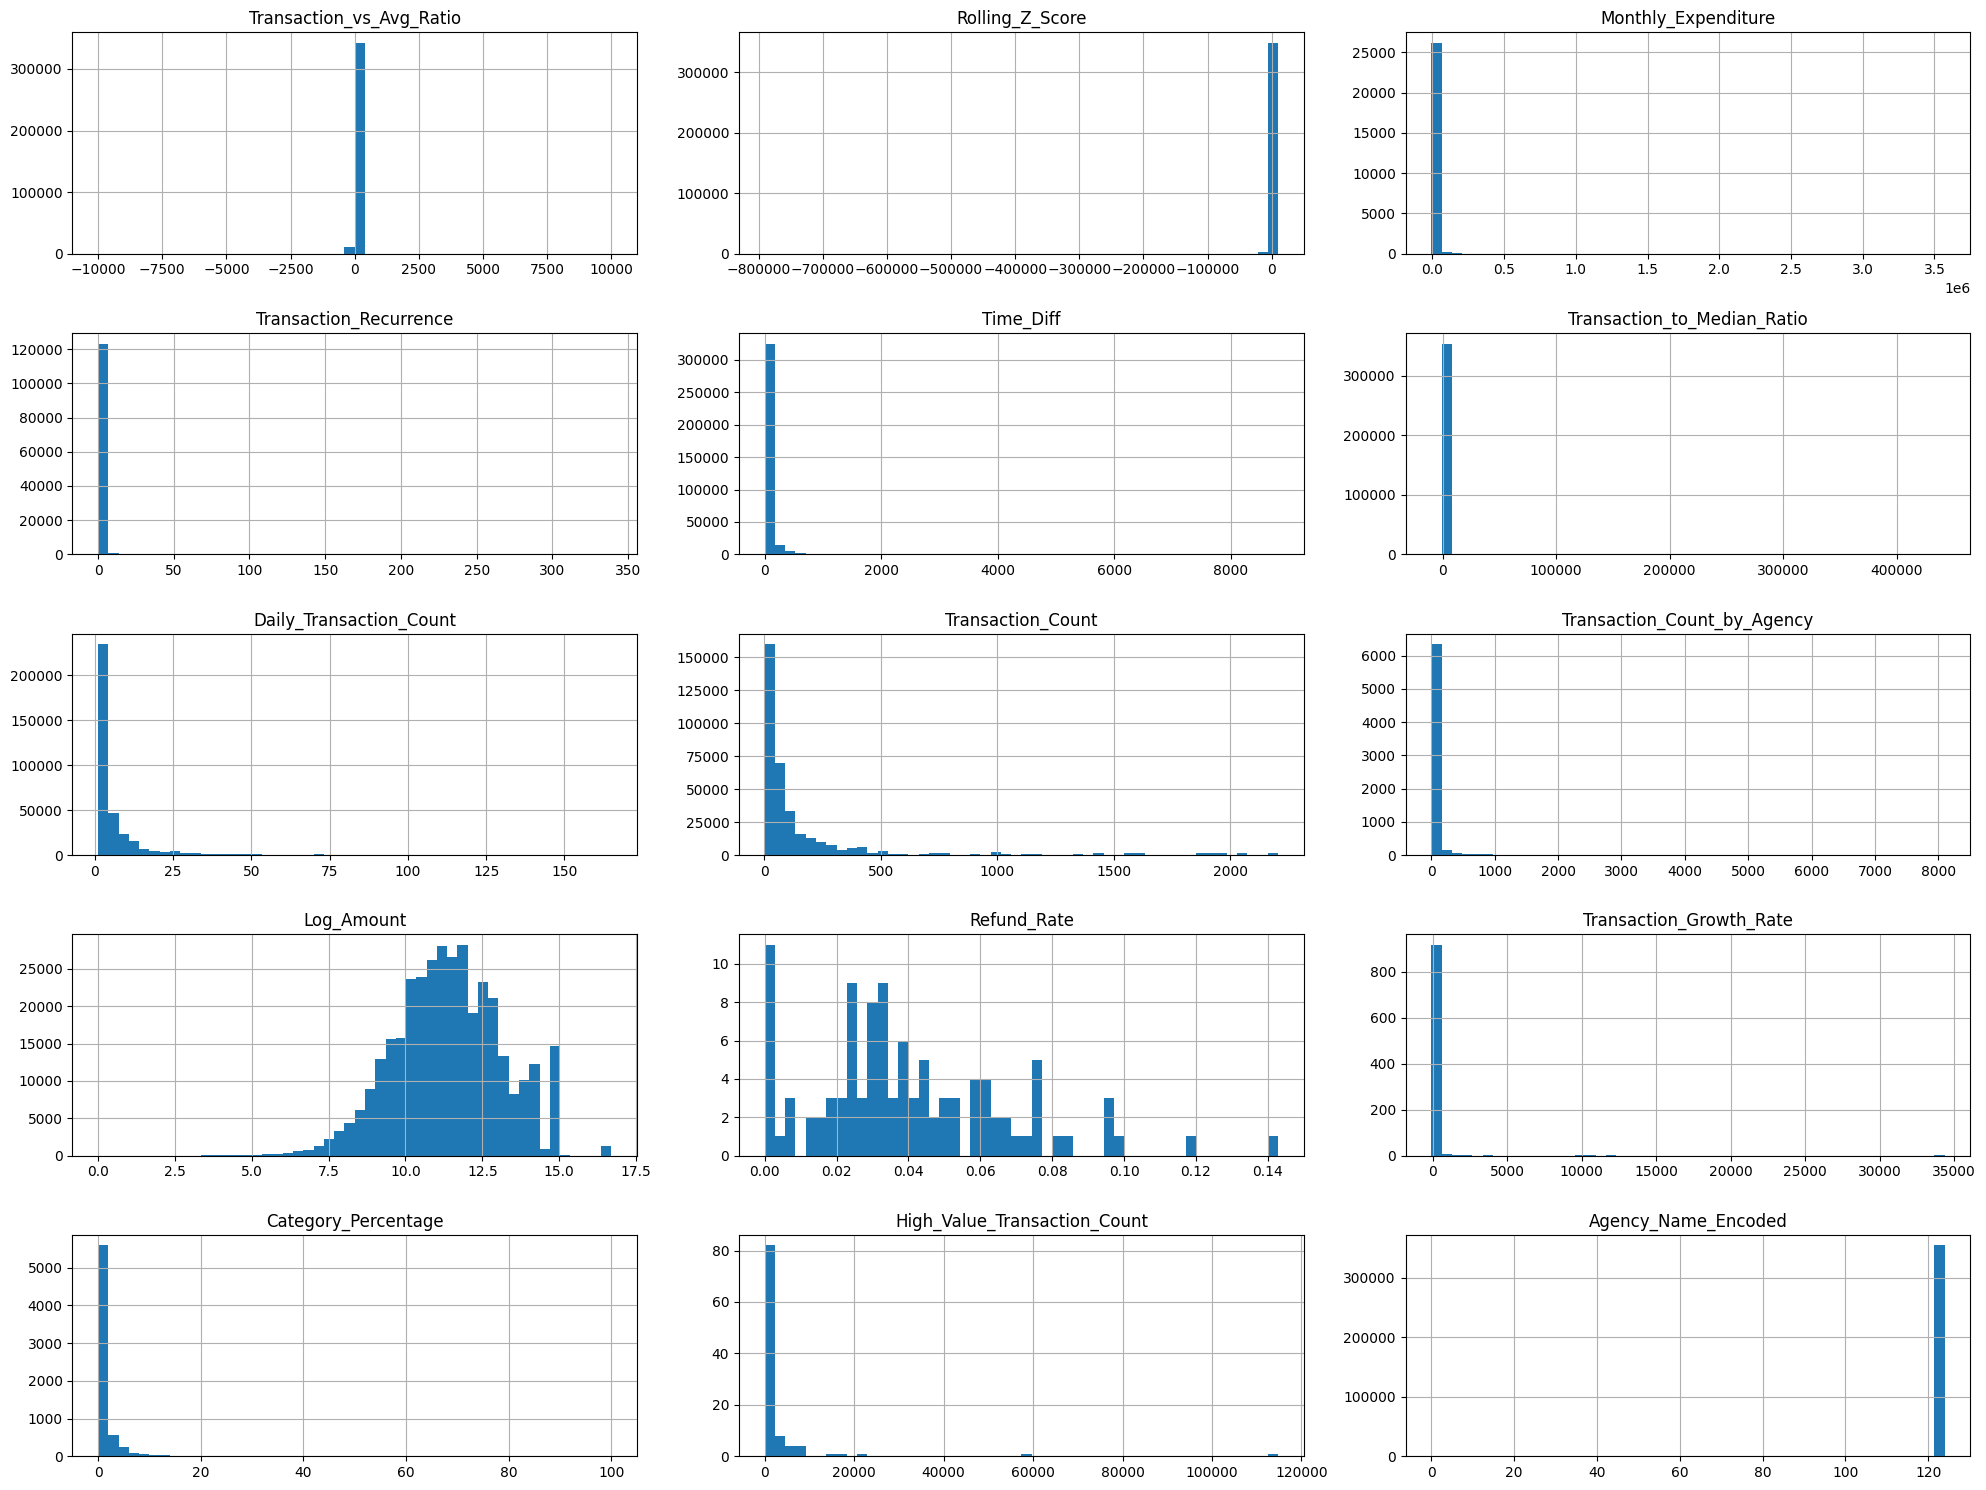

In [24]:
# Adjusting figsize and layout for clarity
pd.DataFrame(X_train).hist(figsize=(20, 15), layout=(5, 3), bins=50)
plt.tight_layout()  # This will adjust subplots to fit into the figure area.
plt.show()


## Running HBOS Model for Each Feature Separately

Given the high NaN content in the dataset, we will run the HBOS model independently for each feature. This allows us to handle missing values for each feature separately, maximizing data usage. The contamination rate is set to 0.05, meaning we expect 5% of the data points to be outliers.

### Steps:
1. **Handle NaNs for Each Feature**: We drop NaNs only for the specific feature being analyzed, without affecting the other features.
2. **Fit HBOS Model**: For each feature, the HBOS model is fitted with a contamination rate of 0.05.
3. **Calculate and Store Anomaly Scores**: For each feature, the anomaly scores are calculated for both the training and test datasets.
4. **Predict and Analyze Outliers**: The outliers (binary labels 0 or 1) are predicted for each feature, and the results are stored for further analysis.
5. **Threshold Calculation**: The threshold used by the HBOS model to classify outliers is recorded for each feature.

The results will provide insights into the distribution of outliers and normal points for each feature separately.


In [25]:
from pyod.models.hbos import HBOS

# Dictionary to store the models, scores, predictions, and statistics for each feature
hbos_models = {}
train_scores = {}
train_preds = {}
test_scores = {}
test_preds = {}
stats_train = {}
stats_test = {}

def count_stat(vector):
    """Counts the number of inliers (0) and outliers (1) in the prediction results."""
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

# Loop through each column in X_train
for column in X_train.columns:
    # Drop NaNs from both training and test datasets for the current column
    train_series = X_train[column].dropna()
    test_series = X_test[column].dropna()

    # Reshape the data (HBOS requires a 2D array)
    train_data = train_series.values.reshape(-1, 1)
    test_data = test_series.values.reshape(-1, 1)
    
    # Initialize the HBOS model with a contamination rate of 0.05
    hbos = HBOS(contamination=0.05)
    
    # Fit the model on the training data
    hbos.fit(train_data)
    
    # Store the model
    hbos_models[column] = hbos
    
    # Get and store the prediction scores
    train_scores[column] = hbos.decision_function(train_data)
    test_scores[column] = hbos.decision_function(test_data)
    
    # Get and store the predictions
    train_preds[column] = hbos.predict(train_data)
    test_preds[column] = hbos.predict(test_data)

    # Store statistics
    stats_train[column] = count_stat(train_preds[column])
    stats_test[column] = count_stat(test_preds[column])

# Print the threshold and statistics for each feature
for column in X_train.columns:
    print(f"\n--- {column} ---")
    print("Threshold for the defined contamination rate:", hbos_models[column].threshold_)
    print("Training data:", stats_train[column])
    print("Test data:", stats_test[column])



--- Transaction_vs_Avg_Ratio ---
Threshold for the defined contamination rate: 3.314969455502225
Training data: {np.int64(0): np.int64(342286), np.int64(1): np.int64(11680)}
Test data: {np.int64(0): np.int64(85614), np.int64(1): np.int64(2878)}

--- Rolling_Z_Score ---
Threshold for the defined contamination rate: 3.3217478815952157
Training data: {np.int64(0): np.int64(350819), np.int64(1): np.int64(41)}
Test data: {np.int64(0): np.int64(87681), np.int64(1): np.int64(18)}

--- Monthly_Expenditure ---
Threshold for the defined contamination rate: 3.3218878105586613
Training data: {np.int64(0): np.int64(26425), np.int64(1): np.int64(16)}
Test data: {np.int64(0): np.int64(6680), np.int64(1): np.int64(8)}

--- Transaction_Recurrence ---
Threshold for the defined contamination rate: 2.9493917423381646
Training data: {np.int64(0): np.int64(124138), np.int64(1): np.int64(151)}
Test data: {np.int64(0): np.int64(31216), np.int64(1): np.int64(29)}

--- Time_Diff ---
Threshold for the defined c

## Running HBOS Model: Step-by-Step Analysis

We applied the HBOS model independently for each feature to handle the high NaN content without losing important data. Here’s how we processed each feature:

1. **Dropped NaNs for Each Feature**: For every feature, we handled missing values by dropping NaNs only for the current feature, avoiding the removal of entire rows with missing data in other features.
2. **Fit HBOS Model with 5% Contamination**: The HBOS model was run for each feature with a contamination rate of 0.05, which marks 5% of data as potential outliers.
3. **Thresholds and Predictions**: For each feature, the model calculated a threshold to classify outliers and provided predictions on training and test data.
4. **Results**: We have captured the decision scores and outlier predictions for further investigation.

### Key Results Summary:

- **Transaction_vs_Avg_Ratio**: Threshold of 3.31, with 11,680 outliers in the training data and 2,878 in the test data. 
- **Rolling_Z_Score**: Very few outliers were found, which suggests this feature is more stable.
- **Monthly_Expenditure**: Few outliers (16 in training, 8 in test data), indicating stable behavior.
- **Log_Amount**: Detected many outliers, which might indicate fraudulent or unusual amounts.
- **Refund_Rate**: Sparse data; only 6 outliers found in training data.
- **Category_Percentage**: This feature shows moderate outliers, potentially indicating shifts in transaction types.


## Setting a Reasonable Threshold for Anomalies

To better understand the anomaly detection process, we visualize the distribution of anomaly scores for each feature. The HBOS model automatically sets a threshold based on the contamination rate of 0.05, but we can inspect the histogram to determine if this threshold should be adjusted.

- **Step 1**: We plot a histogram of the anomaly scores for each feature.
- **Step 2**: A dashed line is added to represent the HBOS threshold.
- **Step 3**: We propose adjustments if the threshold appears to classify too many or too few points as anomalies.


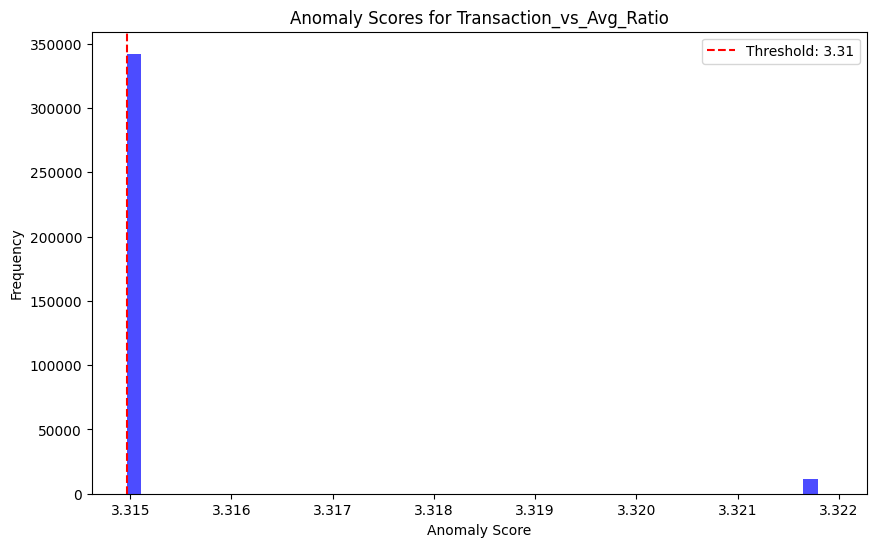

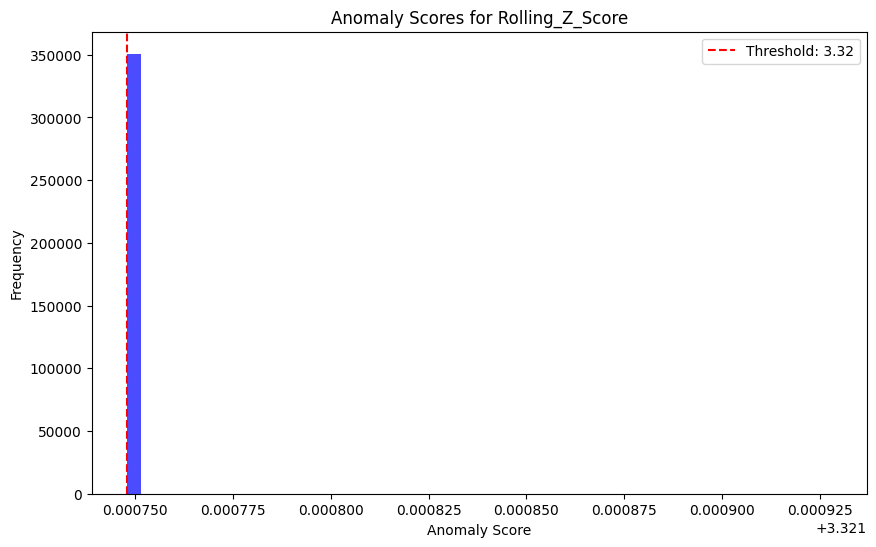

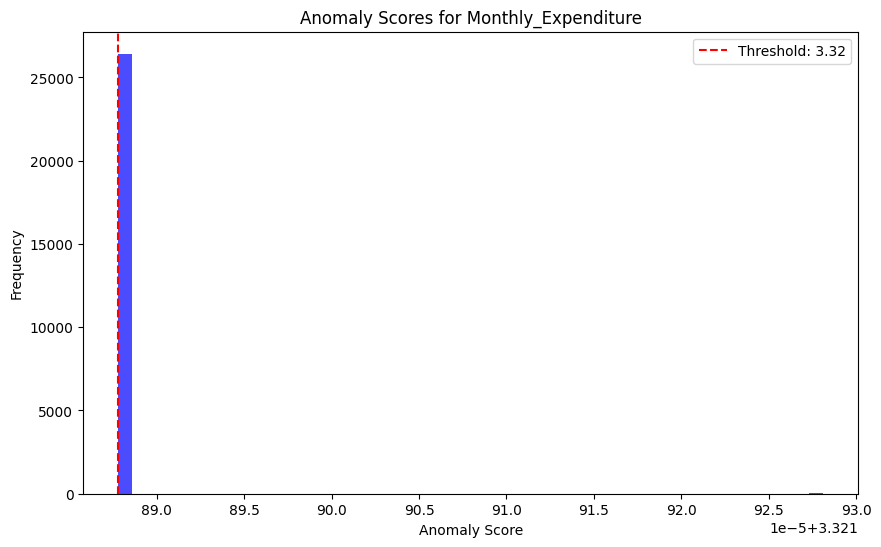

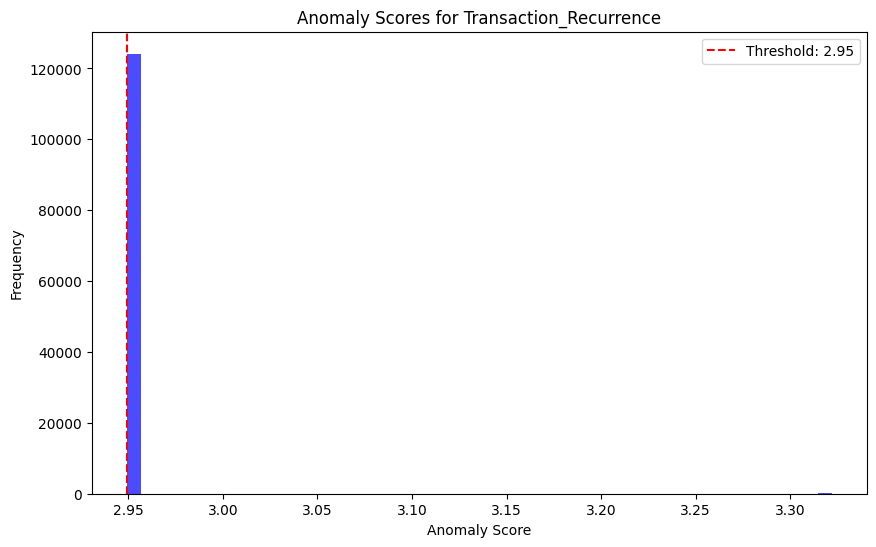

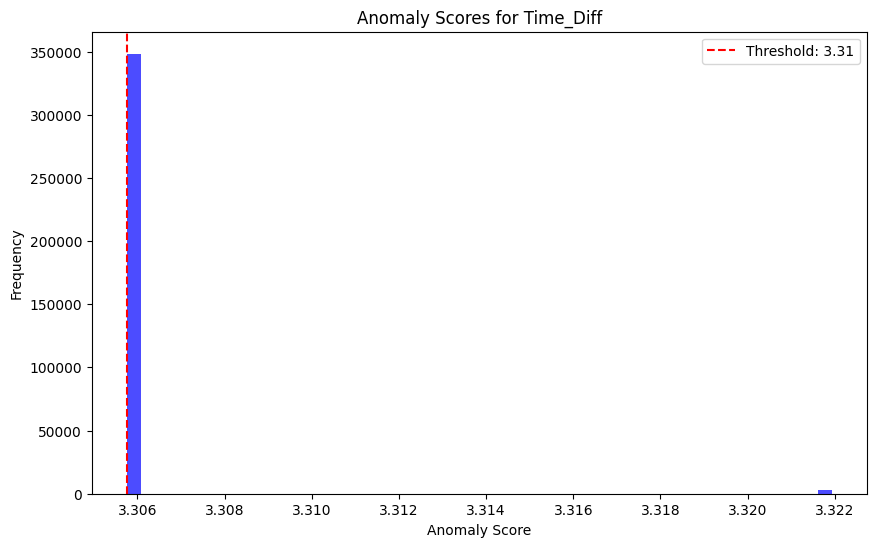

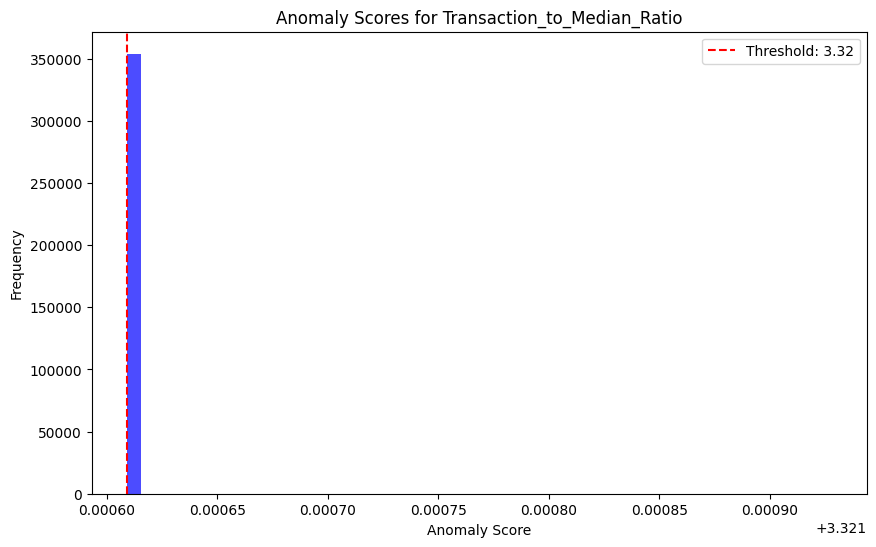

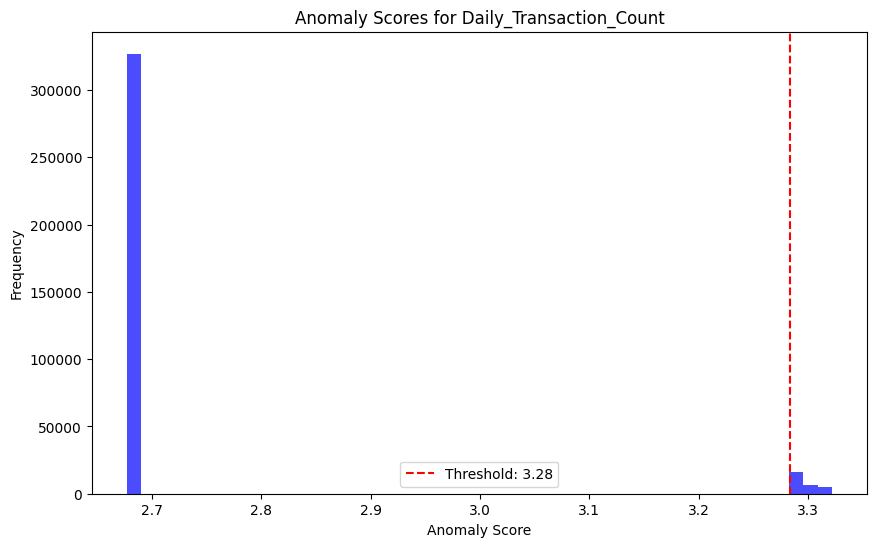

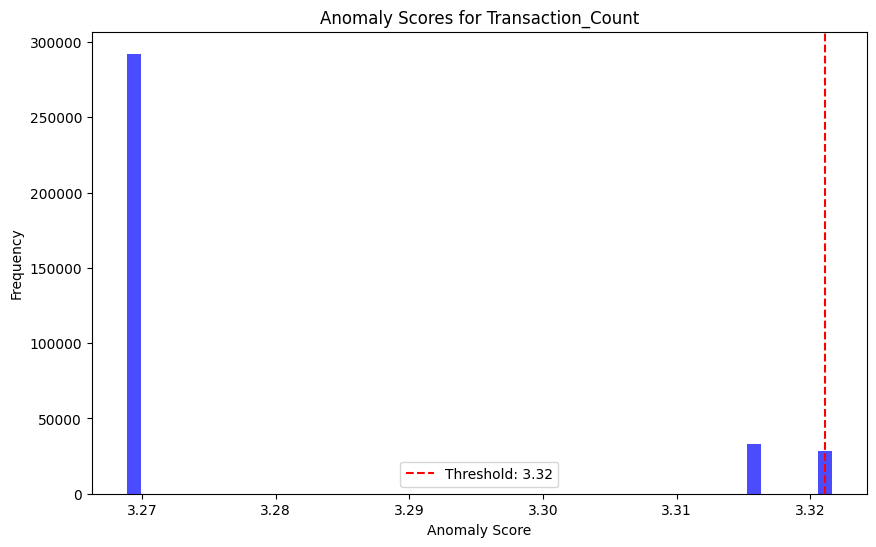

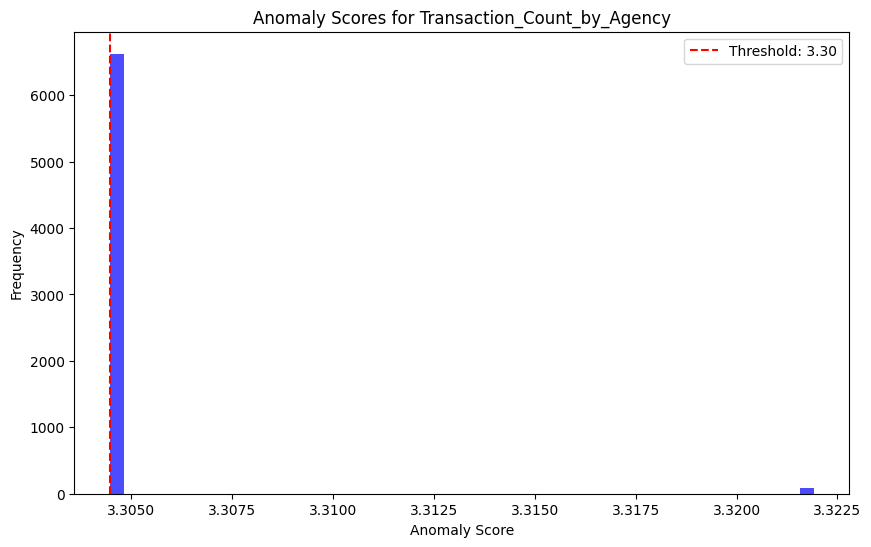

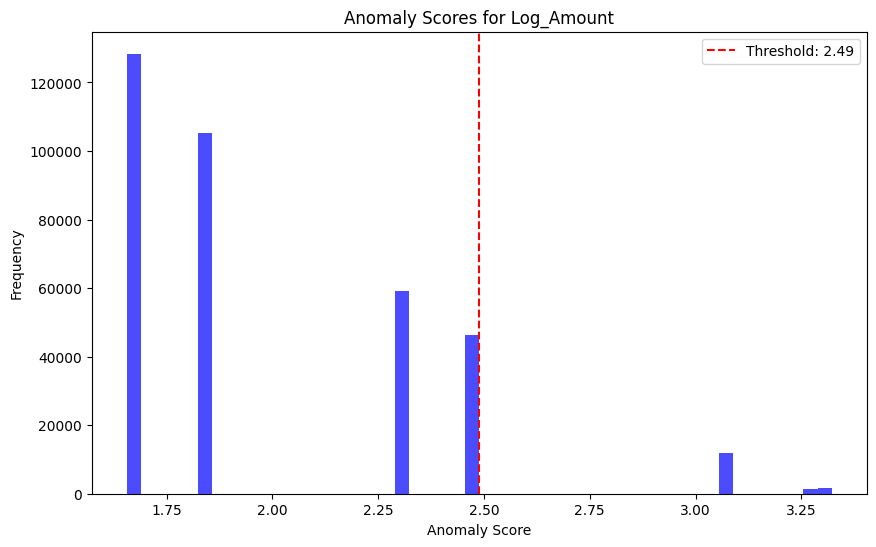

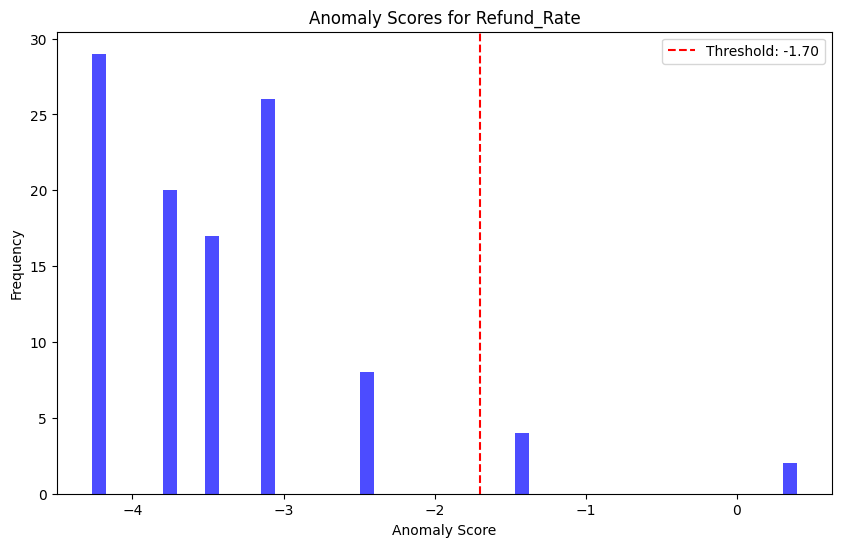

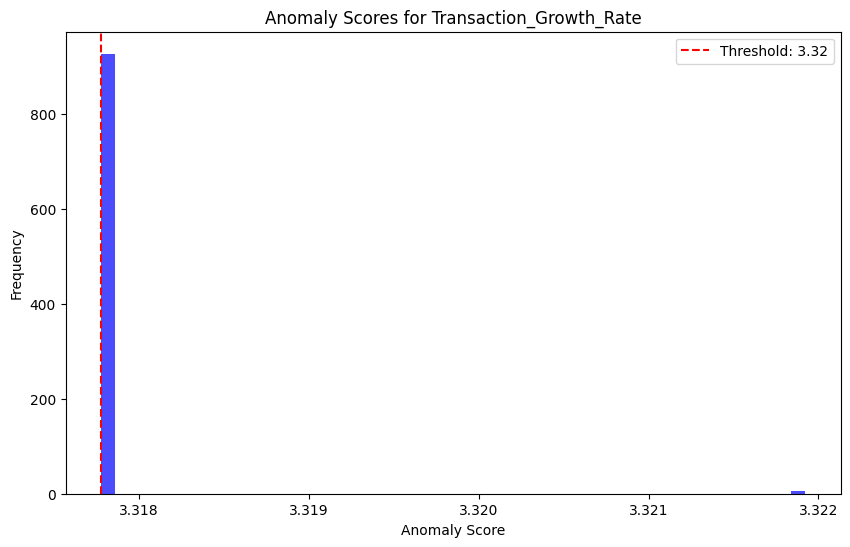

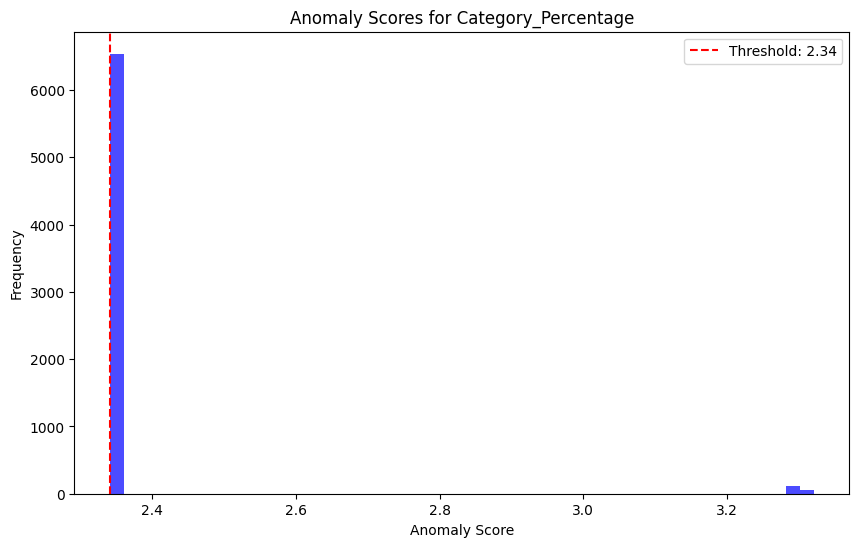

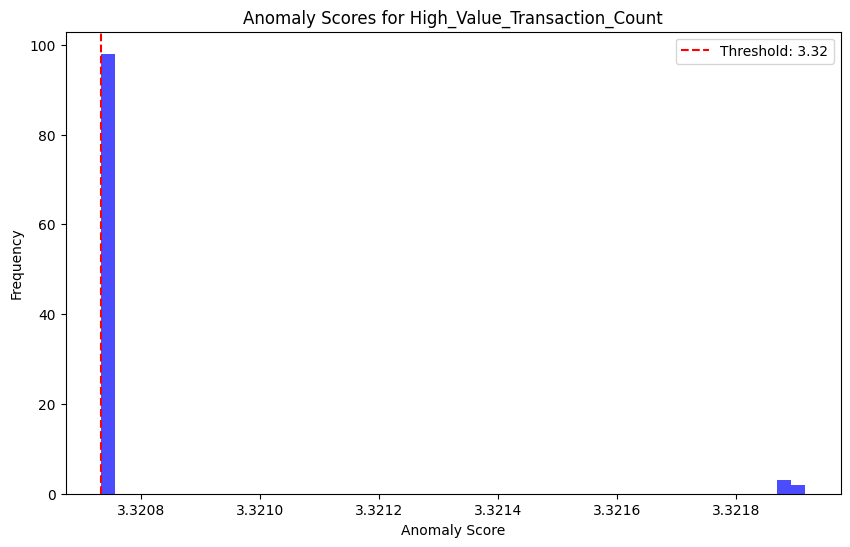

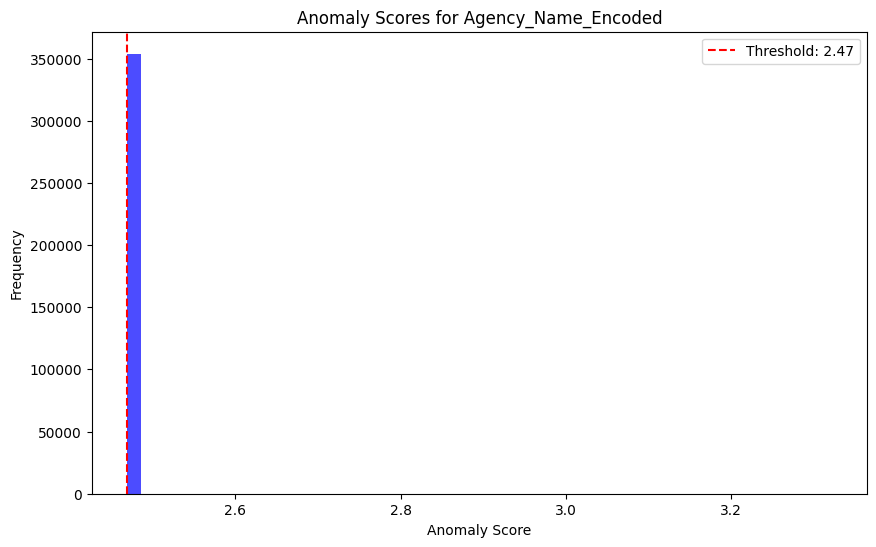

In [26]:
# Visualizing anomaly scores and HBOS thresholds for each feature
for column in X_train.columns:
    # Get the anomaly scores for the training data
    scores = train_scores[column]
    
    # Get the HBOS threshold for this feature
    threshold = hbos_models[column].threshold_
    
    # Plot histogram of anomaly scores
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=50, color='blue', alpha=0.7)
    
    # Add a vertical line for the HBOS threshold
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
    
    # Titles and labels
    plt.title(f'Anomaly Scores for {column}')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Show the plot
    plt.show()


## Summary Statistics of Normal and Abnormal Groups

We will calculate and compare the summary statistics (mean, median, standard deviation) for two groups:
- **Normal Group (Inliers)**: Data points classified as normal (prediction = 0).
- **Abnormal Group (Outliers)**: Data points classified as outliers (prediction = 1).

This comparison helps us understand the characteristics of the anomalies flagged by the HBOS model and how they differ from normal data points.


In [27]:
# Calculate summary statistics for normal (inliers) and abnormal (outliers) groups
summary_stats = {}

for column in X_train.columns:
    # Drop NaNs from the column to align with predictions
    train_series = X_train[column].dropna()
    
    # Separate inliers (0) and outliers (1) based on HBOS predictions
    inliers = train_series[train_preds[column] == 0]
    outliers = train_series[train_preds[column] == 1]

    # Compute basic statistics for each group
    stats = {
        'inliers_mean': inliers.mean(),
        'inliers_median': inliers.median(),
        'inliers_std': inliers.std(),
        'outliers_mean': outliers.mean(),
        'outliers_median': outliers.median(),
        'outliers_std': outliers.std()
    }
    
    # Store the summary stats for this column
    summary_stats[column] = stats

# Display summary statistics for each feature
for column, stats in summary_stats.items():
    print(f"\n--- {column} ---")
    print(f"Inliers - Mean: {stats['inliers_mean']}, Median: {stats['inliers_median']}, Std: {stats['inliers_std']}")
    print(f"Outliers - Mean: {stats['outliers_mean']}, Median: {stats['outliers_median']}, Std: {stats['outliers_std']}")



--- Transaction_vs_Avg_Ratio ---
Inliers - Mean: 1.060981695746612, Median: 0.43512911199414456, Std: 2.1324818966369348
Outliers - Mean: -0.8012173848664953, Median: -0.2170913651177391, Std: 261.73072795372065

--- Rolling_Z_Score ---
Inliers - Mean: -85.36172482353214, Median: -5.251722256422169, Std: 823.9698541178485
Outliers - Mean: -499581.49442834745, Median: -486341.21644251054, Std: 208657.90227458256

--- Monthly_Expenditure ---
Inliers - Mean: 4784.117412298959, Median: 1151.93, Std: 14244.251317367556
Outliers - Mean: 1228405.36, Median: 1154110.145, Std: 925439.5741526177

--- Transaction_Recurrence ---
Inliers - Mean: 0.18284489841950088, Median: 0.0, Std: 1.2184019463082376
Outliers - Mean: 78.55629139072848, Median: 62.0, Std: 45.02453194449879

--- Time_Diff ---
Inliers - Mean: 46.31535665267353, Median: 0.0, Std: 101.7747501115452
Outliers - Mean: 1667.4996209249432, Median: 1320.0, Std: 978.4446922220168

--- Transaction_to_Median_Ratio ---
Inliers - Mean: 3.088503

## Summary Statistics - Key Takeaways

Outliers generally show extreme deviations from normal behavior, particularly in **Monthly_Expenditure**, **Transaction_Recurrence**, **Transaction_to_Median_Ratio**, and **High_Value_Transaction_Count**, where their means are significantly higher than those of inliers. Features like **Rolling_Z_Score** and **Log_Amount** also show substantial differences, indicating unusual transaction patterns and amounts. **Refund_Rate** and **Transaction_Growth_Rate** suggest outliers involve higher refund rates and spikes in transaction activity, potentially indicating fraudulent behavior or irregularities.


## Bin Size and HBOS Performance

To create a more robust HBOS model, we build multiple HBOS models using different bin sizes (`[5, 10, 15, 20, 25, 30, 50, 60, 75, 100]`). We aggregate their anomaly scores using four different methods to minimize the risk of overfitting and enhance prediction accuracy:

1. **Average**: Computes the average anomaly score across all models.
2. **Maximum of Maximum (MOM)**: Takes the maximum score from any of the models.
3. **Average of Maximum (AOM)**: Takes the average of the maximum scores from the models.
4. **Maximum of Average (MOA)**: Takes the maximum of the average scores.

This ensemble approach helps to generate a set of outlier scores that better reflect the underlying structure of the data, leading to more stable and accurate outlier detection.


In [29]:
from sklearn.impute import SimpleImputer
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.hbos import HBOS
import numpy as np

# Step 1: Impute missing values (fill NaNs) with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on X_train and transform both X_train and X_test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 2: Standardize the data after imputation
X_train_norm, X_test_norm = standardizer(X_train_imputed, X_test_imputed)

# Step 3: Define the range of bin sizes to test
bin_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 75, 100]
n_clf = len(bin_sizes)  # Number of classifiers (HBOS models with different bin sizes)

# Prepare data structures to store the model results for each bin size
train_scores = np.zeros([X_train_norm.shape[0], n_clf])
test_scores = np.zeros([X_test_norm.shape[0], n_clf])

# Step 4: Fit HBOS models with different bin sizes and store their scores
for i, n_bins in enumerate(bin_sizes):
    hbos = HBOS(n_bins=n_bins, contamination=0.05)
    hbos.fit(X_train_norm)
    
    # Store the decision scores for the current bin size
    train_scores[:, i] = hbos.decision_function(X_train_norm)
    test_scores[:, i] = hbos.decision_function(X_test_norm)

# Step 5: Normalize the decision scores before combining them
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

# Step 6: Apply the aggregation methods on the normalized scores

# 1. Average
train_agg_avg = average(train_scores_norm)
test_agg_avg = average(test_scores_norm)

# 2. Maximum of Maximum (MOM)
train_agg_mom = maximization(train_scores_norm)
test_agg_mom = maximization(test_scores_norm)

# 3. Average of Maximum (AOM)
train_agg_aom = aom(train_scores_norm, n_buckets=5)  # Dividing into 5 buckets
test_agg_aom = aom(test_scores_norm, n_buckets=5)

# 4. Maximum of Average (MOA)
train_agg_moa = moa(train_scores_norm, n_buckets=5)
test_agg_moa = moa(test_scores_norm, n_buckets=5)


## Handling Missing Values and Evaluating HBOS with Different Bin Sizes

Since the dataset contains missing values (NaNs), we impute the missing values by filling them with the mean of each feature. This allows us to proceed with the HBOS models and ensure that they can be applied to the data. After imputation, the data is standardized, and multiple HBOS models are trained using different bin sizes. The decision scores from these models are aggregated using four methods:

1. **Average**: The average anomaly score across all models.
2. **Maximum of Maximum (MOM)**: The maximum score from any of the models.
3. **Average of Maximum (AOM)**: The average of the maximum scores across multiple models.
4. **Maximum of Average (MOA)**: The maximum of the average scores from the models.

This ensemble approach improves the robustness of the anomaly detection by combining results from models with varying bin sizes.


## Visualization of Anomaly Scores for Different Aggregation Methods

To better understand the distribution of the anomaly scores produced by the HBOS models, we visualize the results of the four aggregation methods: **Average**, **Maximum of Maximum (MOM)**, **Average of Maximum (AOM)**, and **Maximum of Average (MOA)**. The histograms show how each aggregation method processes the scores, allowing us to compare their performance in identifying anomalies.

We expect the aggregation methods to provide different perspectives on how anomalies are classified, with some being more sensitive to minor deviations, while others may generalize more.


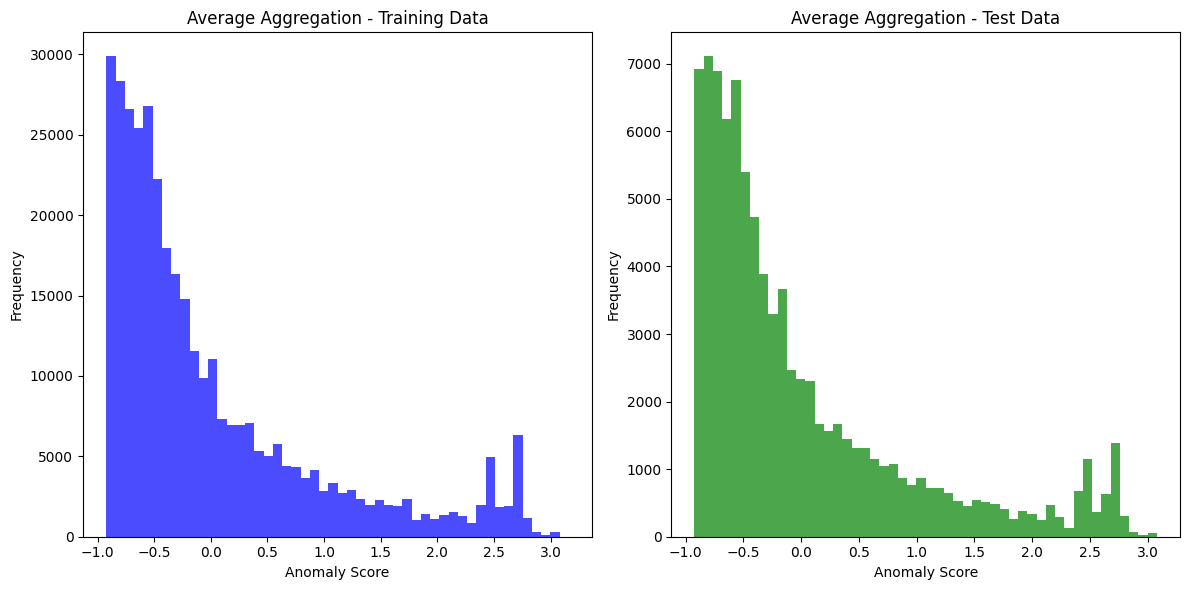

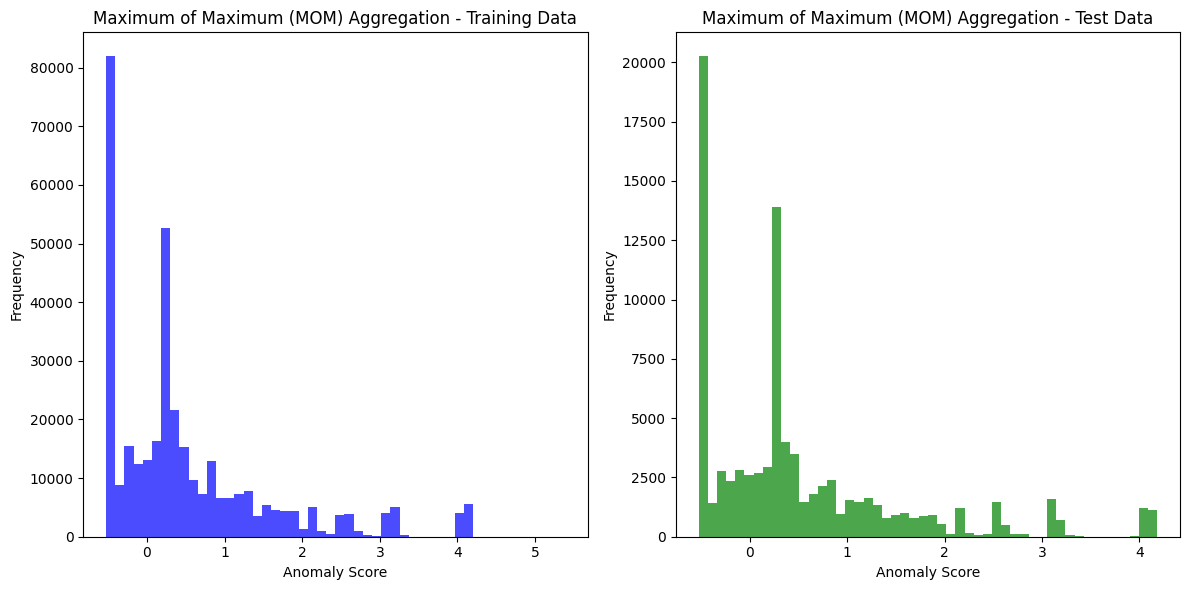

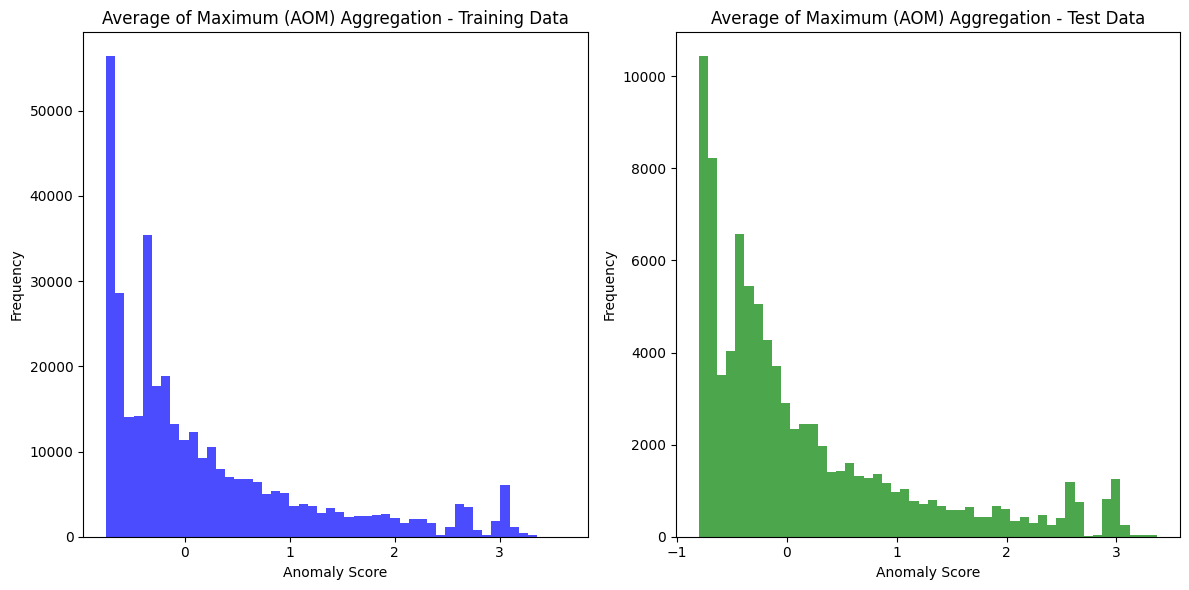

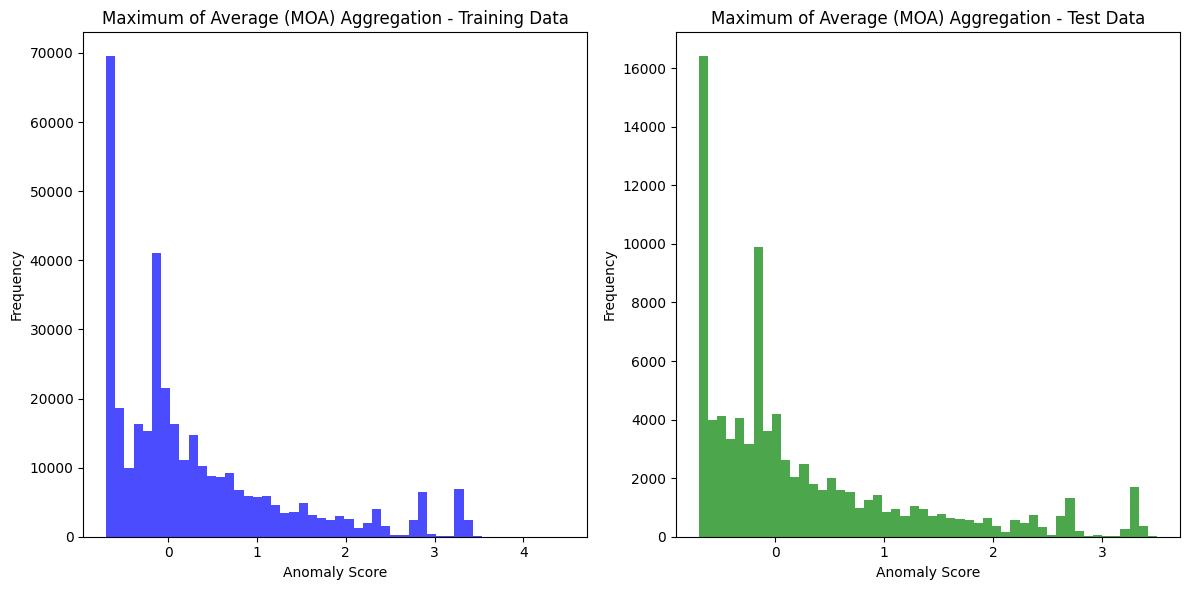

In [30]:
# Function to plot histograms for each aggregation method
def plot_histograms(train_agg, test_agg, title):
    plt.figure(figsize=(12, 6))
    
    # Training data histogram
    plt.subplot(1, 2, 1)
    plt.hist(train_agg, bins=50, color='blue', alpha=0.7)
    plt.title(f'{title} - Training Data')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    
    # Test data histogram
    plt.subplot(1, 2, 2)
    plt.hist(test_agg, bins=50, color='green', alpha=0.7)
    plt.title(f'{title} - Test Data')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Visualize histograms for the different aggregation methods
plot_histograms(train_agg_avg, test_agg_avg, 'Average Aggregation')
plot_histograms(train_agg_mom, test_agg_mom, 'Maximum of Maximum (MOM) Aggregation')
plot_histograms(train_agg_aom, test_agg_aom, 'Average of Maximum (AOM) Aggregation')
plot_histograms(train_agg_moa, test_agg_moa, 'Maximum of Average (MOA) Aggregation')


## Summary of HBOS Algorithm

The Histogram-Based Outlier Score (HBOS) algorithm is designed to detect anomalies by treating each feature independently. In our implementation, we applied HBOS to a variety of features, each with different bin structures. HBOS builds histograms for each feature and assigns outlier scores based on the frequency distribution within those bins. Observations falling into lower-frequency bins (representing rare occurrences) receive higher outlier scores, identifying them as anomalies.

Through different aggregation methods (Average, MOM, AOM, and MOA), we evaluated how combining multiple HBOS models with varying bin sizes impacts anomaly detection. We found that:
- **Average aggregation** provided a balanced approach, identifying both subtle and significant anomalies.
- **Maximum of Maximum (MOM)** was more sensitive to extreme outliers, making it ideal for catching highly unusual observations.
- **AOM and MOA** offered a middle ground, balancing sensitivity to extreme values with generalization across more moderate anomalies.

Overall, HBOS proved to be an efficient anomaly detection method, especially suitable for large datasets. The independent treatment of variables allows HBOS to scale well, while the aggregation of outlier scores provides flexibility in focusing on different types of anomalies depending on the business need.



## Applying ECOD to Each Feature

The ECOD (Empirical Cumulative Distribution Outlier Detection) algorithm is designed to capture outliers based on the empirical cumulative distribution function. For each feature, we will fit an ECOD model and predict anomalies. We will store the anomaly scores and predictions for further analysis.




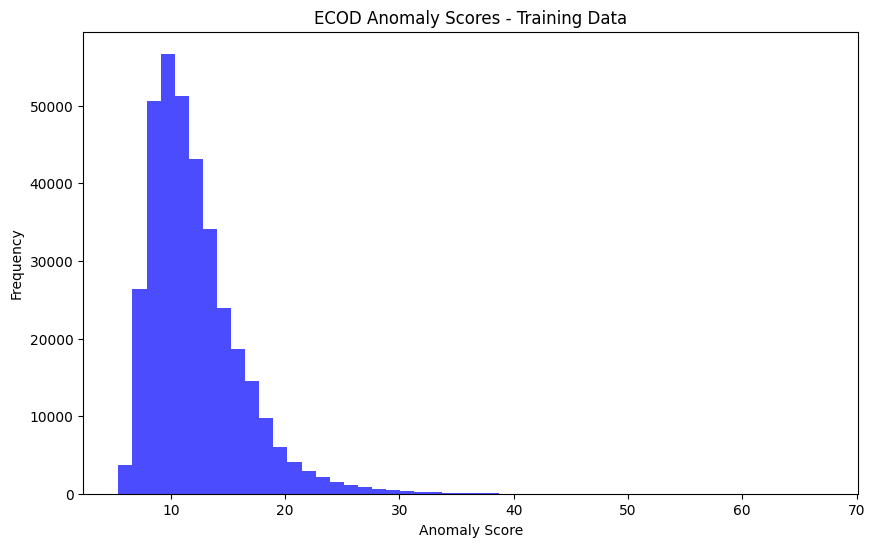

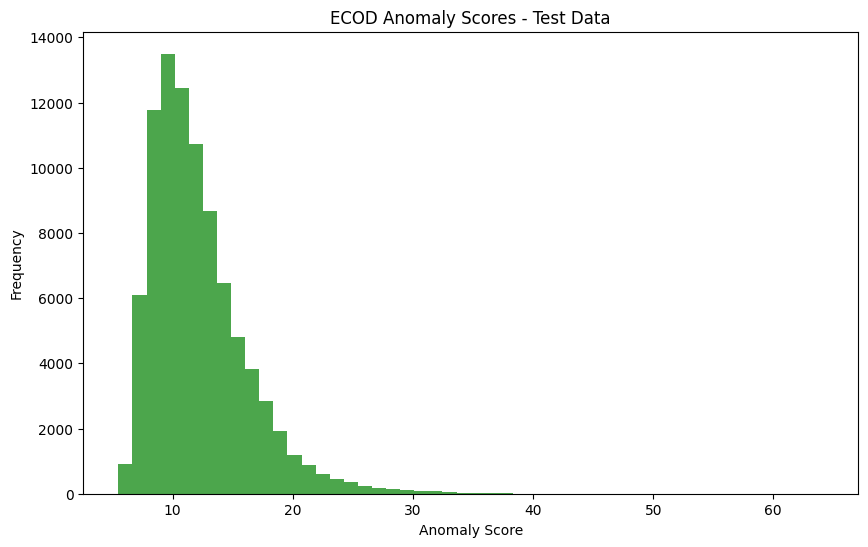

Threshold for the defined contamination rate: 19.598355942634093
Training data prediction counts: {np.int64(0): np.int64(336267), np.int64(1): np.int64(17699)}
Test data prediction counts: {np.int64(0): np.int64(84096), np.int64(1): np.int64(4396)}


In [48]:
from pyod.models.ecod import ECOD
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Handle NaN values using mean imputation
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 2: Initialize and fit ECOD model
ecod = ECOD(contamination=0.05)
ecod.fit(X_train_imputed)

# Step 3: Predict and obtain anomaly scores
y_train_scores = ecod.decision_function(X_train_imputed)  # Training data scores
y_train_pred = ecod.predict(X_train_imputed)  # Training data predictions
y_test_scores = ecod.decision_function(X_test_imputed)  # Test data scores
y_test_pred = ecod.predict(X_test_imputed)  # Test data predictions

# Step 4: Visualize anomaly scores for training and test data
plt.figure(figsize=(10, 6))
plt.hist(y_train_scores, bins=50, color='blue', alpha=0.7)
plt.title("ECOD Anomaly Scores - Training Data")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(y_test_scores, bins=50, color='green', alpha=0.7)
plt.title("ECOD Anomaly Scores - Test Data")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

# Print the threshold and prediction statistics
print(f"Threshold for the defined contamination rate: {ecod.threshold_}")
print(f"Training data prediction counts: {dict(zip(*np.unique(y_train_pred, return_counts=True)))}")
print(f"Test data prediction counts: {dict(zip(*np.unique(y_test_pred, return_counts=True)))}")


### Outlier Detection and Grouping Based on ECOD Scores

A threshold of **25** was chosen based on the ECOD anomaly score distribution. Observations with a score greater than 25 are considered **outliers**, while those with a score below 25 are classified as **normal**.

By grouping the data in this way, we can better understand the behavior of these two groups and determine if any specific patterns exist among the flagged outliers.


In [50]:
# Define the threshold for anomaly detection
threshold = 25

# Grouping the training data based on the threshold
normal_group = X_train_imputed[y_train_scores < threshold]
outlier_group = X_train_imputed[y_train_scores >= threshold]

# Print the sizes of each group
print(f"Number of normal observations: {normal_group.shape[0]}")
print(f"Number of outlier observations: {outlier_group.shape[0]}")

# Calculate and print the mean anomaly score for each group
mean_normal_score = y_train_scores[y_train_scores < threshold].mean()
mean_outlier_score = y_train_scores[y_train_scores >= threshold].mean()

print(f"Mean anomaly score for normal group: {mean_normal_score}")
print(f"Mean anomaly score for outlier group: {mean_outlier_score}")


Number of normal observations: 349439
Number of outlier observations: 4527
Mean anomaly score for normal group: 11.931226869578923
Mean anomaly score for outlier group: 29.323247324890318


In [51]:
# Convert imputed X_train back to DataFrame for easy handling
X_train_df = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Summary statistics for normal group
normal_stats = normal_group.mean(axis=0), normal_group.std(axis=0)

# Summary statistics for outlier group
outlier_stats = outlier_group.mean(axis=0), outlier_group.std(axis=0)

# Display summary statistics
print("\nSummary Statistics for Normal Group (Mean, Std):")
for col, mean, std in zip(X_train.columns, normal_stats[0], normal_stats[1]):
    print(f"{col} - Mean: {mean}, Std: {std}")

print("\nSummary Statistics for Outlier Group (Mean, Std):")
for col, mean, std in zip(X_train.columns, outlier_stats[0], outlier_stats[1]):
    print(f"{col} - Mean: {mean}, Std: {std}")



Summary Statistics for Normal Group (Mean, Std):
Transaction_vs_Avg_Ratio - Mean: 0.9805158783665167, Std: 1.8308677823924897
Rolling_Z_Score - Mean: -136.8392386678468, Std: 5539.856258242955
Monthly_Expenditure - Mean: 5466.68302574255, Std: 3705.228419545835
Transaction_Recurrence - Mean: 0.2749043471256633, Std: 1.8946984199989807
Time_Diff - Mean: 56.62139276387434, Std: 175.5104427780275
Transaction_to_Median_Ratio - Mean: 2.958745718461548, Std: 14.758251641609995
Daily_Transaction_Count - Mean: 6.361665412275104, Std: 11.186501436869017
Transaction_Count - Mean: 176.39285540537833, Std: 365.30234232844015
Transaction_Count_by_Agency - Mean: 55.28172640728622, Std: 7.420166606346044
Log_Amount - Mean: 11.41506547052737, Std: 1.7395240269477577
Refund_Rate - Mean: 0.03959965862435411, Std: 2.518818487118324e-13
Transaction_Growth_Rate - Mean: 103.22857721435943, Std: 0.15747176051259468
Category_Percentage - Mean: 1.5038596160405282, Std: 0.19117659024218198
High_Value_Transacti

### Feature Comparison: Normal vs. Outlier Groups

The following plot compares the mean values of each feature between the **Normal** and **Outlier** groups. This helps to identify the features where outliers exhibit significant deviations from normal observations, which can provide insights into the nature of the detected anomalies.


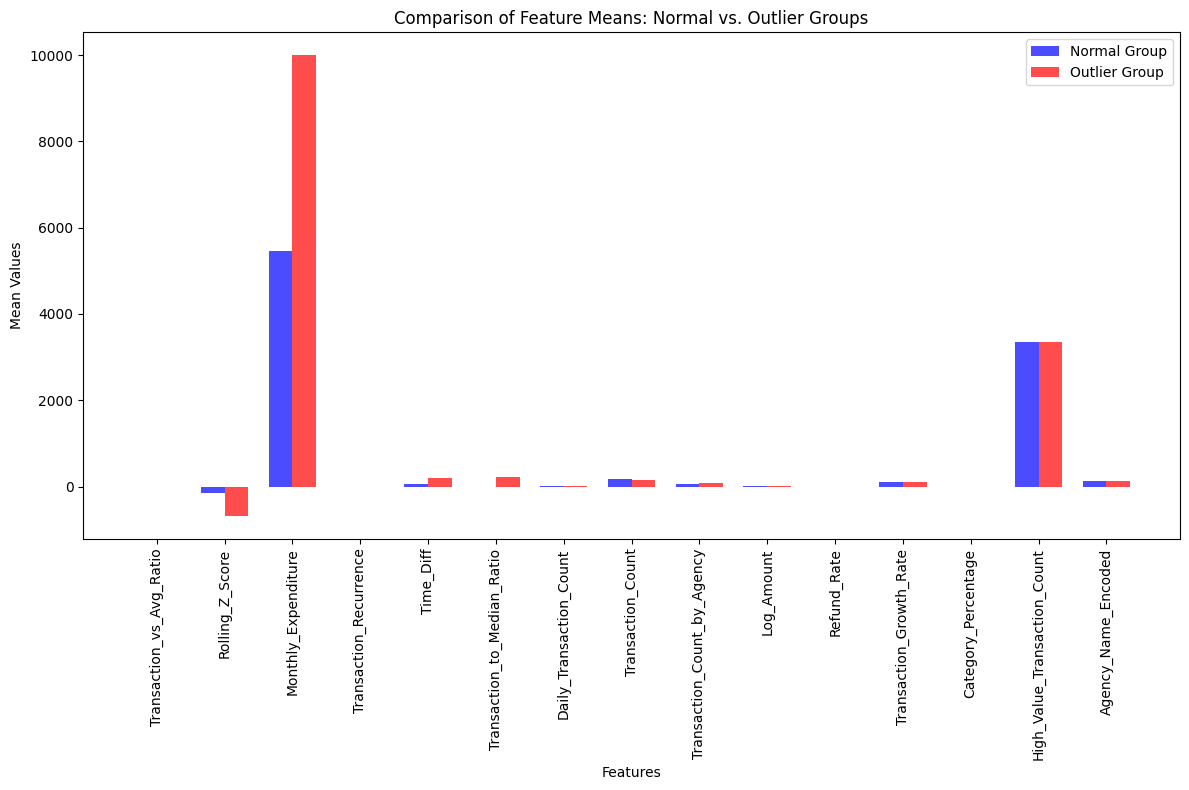

In [52]:
# Get the means of the normal and outlier groups
normal_means = normal_group.mean(axis=0)
outlier_means = outlier_group.mean(axis=0)

# Create a bar plot to compare the feature means
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.35  # Width of bars

# Generate index positions for the number of features
indices = np.arange(len(X_train.columns))

# Plot the means for both normal and outlier groups
ax.bar(indices, normal_means, width, label='Normal Group', color='blue', alpha=0.7)
ax.bar(indices + width, outlier_means, width, label='Outlier Group', color='red', alpha=0.7)

# Set plot labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Feature Means: Normal vs. Outlier Groups')
ax.set_xticks(indices + width / 2)
ax.set_xticklabels(X_train.columns, rotation=90)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


### Takeaways from Feature Comparison: Normal vs. Outlier Groups

1. **Monthly_Expenditure** shows a significant difference between normal and outlier groups, with outliers exhibiting higher average expenditures. This suggests that anomalous observations may involve much higher transaction amounts.
   
2. **High_Value_Transaction_Count** also reveals noticeable differences, with outliers showing slightly elevated transaction counts compared to the normal group. This indicates that high-value transactions are more frequent in the outlier group.

3. **Rolling_Z_Score** has negative values for the normal group but positive values for outliers, suggesting that extreme deviations in this feature are correlated with anomalous behavior.

4. Other features like **Transaction_vs_Avg_Ratio**, **Transaction_Count_by_Agency**, and **Refund_Rate** exhibit minimal differences between normal and outlier groups, indicating that these features may not be as critical for distinguishing anomalies.

5. The overall pattern reveals that spending-related features (e.g., **Monthly_Expenditure**) and extreme values (e.g., **Rolling_Z_Score**) play a key role in differentiating anomalies from normal observations in this dataset.

By imputing missing values with the mean, the model might have diluted the impact of some features, as seen by the minimal differences between normal and outlier groups for several variables.


### Final Summary of ECOD Algorithm

The Empirical Cumulative Distribution-based Outlier Detection (ECOD) algorithm leverages cumulative distribution functions to identify outliers. Each feature is analyzed independently, and the anomaly score is derived based on the tail probability of each feature's distribution. Higher anomaly scores indicate that an observation falls in the extreme tail of the distribution, suggesting it is an outlier.

In our analysis:
1. We handled missing values by imputing the mean, allowing the model to process the data fully.
2. ECOD successfully identified anomalies, with the **Monthly_Expenditure** and **High_Value_Transaction_Count** features standing out as key contributors to outlier detection. Outliers in these features exhibited significantly higher transaction values.
3. The anomaly scores for both training and test datasets were visualized, showing a skewed distribution, with most observations having lower scores and fewer observations with extremely high scores.
4. A threshold of 25 was chosen to separate normal observations from outliers, leading to a clear distinction between the groups.

ECOD proved to be an effective and straightforward method for detecting anomalies, particularly in features related to transaction amounts. However, imputing missing values may have reduced the model's sensitivity to certain features, as observed in the limited differences between normal and outlier groups in some cases.
